### Baseball Simulation with DuckDB on Lahnman Database

In this report, we will attempt to simulate a statistically "average" baseball game, through using the Lahman database of games

ReadMe file: https://www.seanlahman.com/files/database/readme2021.txt

https://pybbda.readthedocs.io/en/stable/auto_examples/example_run_expectancy.html#sphx-glr-download-auto-examples-example-run-expectancy-py

https://pypi.org/project/pybbda/

In [1]:
#pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 9.5 MB/s eta 0:00:00:00:010:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 12.0 MB/s eta 0:00:0000:0100:01
  Created wheel for duckdb: filename=duckdb-0.3.3-cp39-cp39-macosx_10_9_x86_64.whl size=12202713 sha256=0b3914a5a4f484a0fd04458716333e6838f5052c026d6a0d5de9a32b6e5a4611
  Stored in directory: /Users/emmaschmidt/Library/Caches/pip/wheels/37/47/74/8419272484edff0f026281885b65610b5c28803492fa7d30d0
Successfully built duckdb
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.2

In [2]:
#import shutil
#dir_name = "/home/jovyan/work/BigData/lahnman-to-duckdb"
#output_filename = 'zipped_work'
#shutil.make_archive(output_filename, 'zip', dir_name)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/work/BigData/lahnman-to-duckdb'

In [3]:
import csv
from importlib.resources import files
from itertools import chain
from pathlib import PosixPath

import duckdb
import os

In [4]:
os.getcwd()
%cd "/Users/emmaschmidt/Baseball_Simulation/"

/Users/emmaschmidt/Baseball_Simulation


In [5]:
SQL = os.listdir('src/sql/')
CORE = os.listdir('src/lahnman/core/')
CONTRIB = os.listdir('src/lahnman/contrib/')
TMP = os.listdir('src/tmp/')

In [6]:
TABLE_ORDER = ['src/lahnman/core/people', 'src/lahnman/core/parks', 'src/lahnman/core/teamsfranchises', 'src/lahnman/core/teams',
               'src/lahnman/contrib/salaries', 'src/lahnman/contrib/schools', 'src/lahnman/core/allstarfull', 'src/lahnman/core/appearances',
               'src/lahnman/contrib/awardsmanagers', 'src/lahnman/contrib/awardsplayers', 'src/lahnman/contrib/awardssharemanagers', 
               'src/lahnman/contrib/awardsshareplayers', 'src/lahnman/core/batting', 'src/lahnman/core/battingpost',
               'src/lahnman/contrib/collegeplaying', 'src/lahnman/core/fielding', 'src/lahnman/core/fieldingof', 
               'src/lahnman/core/fieldingofsplit', 'src/lahnman/core/fieldingpost', 'src/lahnman/contrib/halloffame',
               'src/lahnman/core/homegames','src/lahnman/core/managers', 'src/lahnman/core/managershalf', 'src/lahnman/core/pitching',
               'src/lahnman/core/pitchingpost', 'src/lahnman/core/seriespost', 'src/lahnman/core/teamshalf']

In [7]:
def open_query(fname: PosixPath) -> str:
    with open(fname) as f:
        query = f.read()
    return query


def parse_query_columns(query_path: PosixPath) -> list[str]:
    """Return a list of columns for a given create table statement"""
    cols = []
    query = open_query(query_path)
    if not query.strip().startswith('CREATE TABLE'):
        return cols

    for row in query.split('\n'):
        if row.strip().startswith('"'):
            cols.append(row.strip().split('"')[1])
    return cols


def create_table_data_mapping() -> dict:
    """Return mapping of all table names -> query_path, file_path, create statement columns"""
    core = ['src/lahnman/core/' +  each for each in CORE]
    contrib = ['src/lahnman/contrib/' + each for each in CONTRIB]
    queries = ['src/sql/' + each for each in SQL]
    core.extend(contrib)
    files = core.copy()

    d = {}
    for fname, query in zip(files, queries):  # excludes final index query bc there is no associated file path
        name = fname.replace('.csv', '').lower()

        d[name] = {
            'query_path': query,
            'file_path': fname,
            'cols': parse_query_columns(query),
        }

    return d


def load_all_create_statements(mapping: dict):
    """Join all create statements into a single string"""
    all_queries = ''
    for table in TABLE_ORDER:
        all_queries += open_query(mapping.get(table)['query_path']) + '\n'
    return all_queries


def increment_and_save_csv(fname: PosixPath, fout: PosixPath) -> None:
    """Load csv, add zero-index "ID" column, increment starting at 1, return header and incremented data tuple"""
    results = []

    with open(fout, 'wt') as fo:
        csvwriter = csv.writer(fo)

        with open(fname) as f:
            csvreader = csv.reader(f)
            header = ['ID'] + next(csvreader)
            csvwriter.writerow(header)

            for i, row in enumerate(csvreader, start=1):
                csvwriter.writerow([i] + row)


def main():
    conn = duckdb.connect(database='lahnman.duckdb')
    mapping = create_table_data_mapping()

    create_statements = load_all_create_statements(mapping)
    
    create_statements = create_statements.replace('\n', '')
    create_statements = create_statements.replace('"', '')
    create_statements = ' '.join(create_statements.split())
    
    conn.execute('BEGIN TRANSACTION')
    conn.execute(create_statements)
    conn.execute('COMMIT')
    
    conn.execute('BEGIN TRANSACTION')
    for table in TABLE_ORDER:
        d = mapping.get(table)
        print(table)

        file_path = d['file_path']
        tmp_path = TMP.joinpath(file_path.name)

        # re-write file in tmp/ with ID col and incremented value
        increment_and_save_csv(file_path, tmp_path)

        cols = [c for c in d['cols'] if '_ID' not in c]  # trim foreign keys but leave primary ID

        conn.execute(f"COPY {table}({','.join(cols)}) FROM '{str(tmp_path)}' (DELIMITER ',', HEADER 1);")
    conn.execute('COMMIT')

    # final index query
    conn.execute(open_query(SQL.joinpath('zzz_indicies.sql')))

In [8]:
create_statements = 'CREATE TABLE people (playerID INTEGER NOT NULL, birthYear INTEGER NOT NULL); CREATE TABLE teamsfranchises ( ID INTEGER NOT NULL, franchID VARCHAR(50) NULL, franchName VARCHAR(50) NULL, active CHARACTER(1) NULL, NAassoc VARCHAR(3) NULL, PRIMARY KEY (ID));CREATE TABLE teams ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NULL, teamID CHARACTER(3) NOT NULL, franchID VARCHAR(3) NULL, divID CHARACTER(1) NULL, div_ID INTEGER NULL, teamRank SMALLINT NULL, G SMALLINT NULL, Ghome SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, DivWin VARCHAR(1) NULL, WCWin VARCHAR(1) NULL, LgWin VARCHAR(1) NULL, WSWin VARCHAR(1) NULL, R SMALLINT NULL, AB SMALLINT NULL, H SMALLINT NULL, B2 SMALLINT NULL, B3 SMALLINT NULL, HR SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, HBP SMALLINT NULL, SF SMALLINT NULL, RA SMALLINT NULL, ER SMALLINT NULL, ERA DOUBLE NULL, CG SMALLINT NULL, SHO SMALLINT NULL, SV SMALLINT NULL, IPouts INTEGER NULL, HA SMALLINT NULL, HRA SMALLINT NULL, BBA SMALLINT NULL, SOA SMALLINT NULL, E INTEGER NULL, DP INTEGER NULL, FP DOUBLE NULL, name VARCHAR(50) NULL, park VARCHAR(255) NULL, attendance INTEGER NULL, BPF INTEGER NULL, PPF INTEGER NULL, teamIDBR VARCHAR(3) NULL, teamIDlahman45 VARCHAR(3) NULL, teamIDretro VARCHAR(3) NULL, PRIMARY KEY (ID), FOREIGN KEY(franchID) REFERENCES teamsfranchises (franchID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE schools ( ID INTEGER NOT NULL, schoolID VARCHAR(15) NOT NULL, name_full VARCHAR(255) NULL, city VARCHAR(55) NULL, state VARCHAR(55) NULL, country VARCHAR(55) NULL, PRIMARY KEY (ID));CREATE TABLE parks ( ID INTEGER NOT NULL, parkalias VARCHAR(255) NULL, parkkey VARCHAR(255) NULL, parkname VARCHAR(255) NULL, city VARCHAR(255) NULL, state VARCHAR(255) NULL, country VARCHAR(255) NULL, PRIMARY KEY (ID));CREATE TABLE homegames ( ID INTEGER NOT NULL, yearkey INTEGER NULL, leaguekey CHARACTER(2) NULL, teamkey CHARACTER(3) NULL, team_ID INTEGER NULL, parkkey VARCHAR(255) NULL, park_ID INTEGER NULL, spanfirst VARCHAR(255) NULL, spanlast VARCHAR(255) NULL, games INTEGER NULL, openings INTEGER NULL, attendance INTEGER NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(park_ID) REFERENCES parks (ID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE awardssharemanagers ( ID INTEGER NOT NULL, awardID VARCHAR(25) NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NOT NULL, playerID VARCHAR(10) NOT NULL, pointsWon SMALLINT NULL, pointsMax SMALLINT NULL, votesFirst SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE fieldingof ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, stint SMALLINT NOT NULL, Glf SMALLINT NULL, Gcf SMALLINT NULL, Grf SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE fieldingofsplit ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, stint SMALLINT NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, POS VARCHAR(2) NOT NULL, G SMALLINT NULL, GS SMALLINT NULL, InnOuts SMALLINT NULL, PO SMALLINT NULL, A SMALLINT NULL, E SMALLINT NULL, DP SMALLINT NULL, PB SMALLINT NULL, WP SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, ZR DOUBLE NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE awardsplayers ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, awardID VARCHAR(255) NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NULL, tie VARCHAR(1) NULL, notes VARCHAR(100) NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE pitchingpost ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, round VARCHAR(10) NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, W SMALLINT NULL, L SMALLINT NULL, G SMALLINT NULL, GS SMALLINT NULL, CG SMALLINT NULL, SHO SMALLINT NULL, SV SMALLINT NULL, IPouts INTEGER NULL, H SMALLINT NULL, ER SMALLINT NULL, HR SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, BAOpp DOUBLE NULL, ERA DOUBLE NULL, IBB SMALLINT NULL, WP SMALLINT NULL, HBP SMALLINT NULL, BK SMALLINT NULL, BFP SMALLINT NULL, GF SMALLINT NULL, R SMALLINT NULL, SH SMALLINT NULL, SF SMALLINT NULL, GIDP SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE managershalf ( ID INTEGER NOT NULL, playerID VARCHAR(10) NOT NULL, yearID SMALLINT NOT NULL, teamID CHARACTER(3) NOT NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, inseason SMALLINT NULL, half SMALLINT NOT NULL, G SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, teamRank SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE teamshalf ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NOT NULL, teamID CHARACTER(3) NOT NULL, team_ID INTEGER NULL, Half VARCHAR(1) NOT NULL, divID CHARACTER(1) NULL, div_ID INTEGER NULL, DivWin VARCHAR(1) NULL, teamRank SMALLINT NULL, G SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE appearances ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, teamID CHARACTER(3) NOT NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, playerID VARCHAR(9) NOT NULL, G_all SMALLINT NULL, GS SMALLINT NULL, G_batting SMALLINT NULL, G_defense SMALLINT NULL, G_p SMALLINT NULL, G_c SMALLINT NULL, G_1b SMALLINT NULL, G_2b SMALLINT NULL, G_3b SMALLINT NULL, G_ss SMALLINT NULL, G_lf SMALLINT NULL, G_cf SMALLINT NULL, G_rf SMALLINT NULL, G_of SMALLINT NULL, G_dh SMALLINT NULL, G_ph SMALLINT NULL, G_pr SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE salaries ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, teamID CHARACTER(3) NOT NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NOT NULL, playerID VARCHAR(9) NOT NULL, salary DOUBLE NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE fieldingpost ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, round VARCHAR(10) NOT NULL, POS VARCHAR(2) NOT NULL, G SMALLINT NULL, GS SMALLINT NULL, InnOuts SMALLINT NULL, PO SMALLINT NULL, A SMALLINT NULL, E SMALLINT NULL, DP SMALLINT NULL, TP SMALLINT NULL, PB SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE pitching ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, stint SMALLINT NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, W SMALLINT NULL, L SMALLINT NULL, G SMALLINT NULL, GS SMALLINT NULL, CG SMALLINT NULL, SHO SMALLINT NULL, SV SMALLINT NULL, IPouts INTEGER NULL, H SMALLINT NULL, ER SMALLINT NULL, HR SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, BAOpp DOUBLE NULL, ERA DOUBLE NULL, IBB SMALLINT NULL, WP SMALLINT NULL, HBP SMALLINT NULL, BK SMALLINT NULL, BFP SMALLINT NULL, GF SMALLINT NULL, R SMALLINT NULL, SH SMALLINT NULL, SF SMALLINT NULL, GIDP SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE seriespost ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, round VARCHAR(5) NOT NULL, teamIDwinner VARCHAR(3) NULL, lgIDwinner VARCHAR(2) NULL, team_IDwinner INTEGER NULL, teamIDloser VARCHAR(3) NULL, team_IDloser INTEGER NULL, lgIDloser VARCHAR(2) NULL, wins SMALLINT NULL, losses SMALLINT NULL, ties SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_IDwinner) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(team_IDloser) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE awardsshareplayers ( ID INTEGER NOT NULL, awardID VARCHAR(25) NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NOT NULL, playerID VARCHAR(9) NOT NULL, pointsWon DOUBLE NULL, pointsMax SMALLINT NULL, votesFirst DOUBLE NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE managers ( ID INTEGER NOT NULL, playerID VARCHAR(10) NULL, yearID SMALLINT NOT NULL, teamID CHARACTER(3) NOT NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, inseason SMALLINT NOT NULL, G SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, teamRank SMALLINT NULL, plyrMgr VARCHAR(1) NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE collegeplaying ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, schoolID VARCHAR(15) NULL, yearID SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(schoolID) REFERENCES schools (schoolID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE fielding ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, stint SMALLINT NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, POS VARCHAR(2) NOT NULL, G SMALLINT NULL, GS SMALLINT NULL, InnOuts SMALLINT NULL, PO SMALLINT NULL, A SMALLINT NULL, E SMALLINT NULL, DP SMALLINT NULL, PB SMALLINT NULL, WP SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, ZR DOUBLE NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE battingpost ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, round VARCHAR(10) NOT NULL, playerID VARCHAR(9) NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, G SMALLINT NULL, AB SMALLINT NULL, R SMALLINT NULL, H SMALLINT NULL, B2 SMALLINT NULL, B3 SMALLINT NULL, HR SMALLINT NULL, RBI SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, IBB SMALLINT NULL, HBP SMALLINT NULL, SH SMALLINT NULL, SF SMALLINT NULL, GIDP SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE awardsmanagers ( ID INTEGER NOT NULL, playerID VARCHAR(10) NOT NULL, awardID VARCHAR(75) NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NOT NULL, tie VARCHAR(1) NULL, notes VARCHAR(100) NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE INDEX allstarfull_team_ID ON allstarfull (team_ID);CREATE INDEX appearances_playerID ON appearances (playerID);CREATE INDEX appearances_team_ID ON appearances (team_ID);CREATE UNIQUE INDEX appearances_yearID ON appearances (yearID, teamID, playerID);CREATE UNIQUE INDEX batting_playerID ON batting (playerID, yearID, stint);CREATE INDEX batting_team_ID ON batting (team_ID);CREATE INDEX battingpost_playerID ON battingpost (playerID);CREATE INDEX battingpost_team_ID ON battingpost (team_ID);CREATE UNIQUE INDEX battingpost_yearID ON battingpost (yearID, round, playerID);CREATE INDEX collegeplaying_playerID ON collegeplaying (playerID);CREATE INDEX collegeplaying_schoolID ON collegeplaying (schoolID);CREATE UNIQUE INDEX fielding_playerID ON fielding (playerID, yearID, stint, POS);CREATE INDEX fielding_team_ID ON fielding (team_ID);CREATE UNIQUE INDEX fieldingof_playerID ON fieldingof (playerID, yearID, stint);CREATE UNIQUE INDEX fieldingofsplit_playerID ON fieldingofsplit (playerID, yearID, stint, POS);CREATE INDEX fieldingofsplit_team_ID ON fieldingofsplit (team_ID);CREATE UNIQUE INDEX fieldingpost_playerID ON fieldingpost (playerID, yearID, round, POS);CREATE INDEX fieldingpost_team_ID ON fieldingpost (team_ID);CREATE UNIQUE INDEX halloffame_playerID ON halloffame (playerID, yearid, votedBy);CREATE INDEX homegames_park_ID ON homegames (park_ID);CREATE INDEX homegames_team_ID ON homegames (team_ID);CREATE INDEX managers_playerID ON managers (playerID);CREATE INDEX managers_team_ID ON managers (team_ID);CREATE UNIQUE INDEX managers_yearID ON managers (yearID, teamID, inseason);CREATE UNIQUE INDEX managershalf_playerID ON managershalf (playerID, yearID, teamID, half);CREATE INDEX managershalf_team_ID ON managershalf (team_ID);CREATE UNIQUE INDEX pitching_playerID ON pitching (playerID, yearID, stint);CREATE INDEX pitching_team_ID ON pitching (team_ID);CREATE UNIQUE INDEX pitchingpost_playerID ON pitchingpost (playerID, yearID, round);CREATE INDEX pitchingpost_team_ID ON pitchingpost (team_ID);CREATE INDEX salaries_playerID ON salaries (playerID);CREATE INDEX salaries_team_ID ON salaries (team_ID);CREATE INDEX seriespost_team_IDloser ON seriespost (team_IDloser);CREATE INDEX seriespost_team_IDwinner ON seriespost (team_IDwinner);CREATE UNIQUE INDEX seriespost_yearID ON seriespost (yearID, round);CREATE INDEX teams_div_ID ON teams (div_ID);CREATE INDEX teams_franchID ON teams (franchID);CREATE INDEX teamshalf_div_ID ON teamshalf (div_ID);CREATE INDEX teamshalf_team_ID ON teamshalf (team_ID);CREATE TABLE batting ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NOT NULL, stint SMALLINT NOT NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, G SMALLINT NULL, AB SMALLINT NULL, R SMALLINT NULL, H SMALLINT NULL, B2 SMALLINT NULL, B3 SMALLINT NULL, HR SMALLINT NULL, RBI SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, IBB SMALLINT NULL, HBP SMALLINT NULL, SH SMALLINT NULL, SF SMALLINT NULL, GIDP SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION, FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE allstarfull ( ID INTEGER NOT NULL, playerID VARCHAR(9) NOT NULL, yearID SMALLINT NULL, gameNum SMALLINT NOT NULL, gameID VARCHAR(12) NULL, teamID CHARACTER(3) NULL, team_ID INTEGER NULL, lgID CHARACTER(2) NULL, GP SMALLINT NULL, startingPos SMALLINT NULL, PRIMARY KEY (ID), FOREIGN KEY(team_ID) REFERENCES teams (ID) ON UPDATE NO ACTION ON DELETE NO ACTION);CREATE TABLE halloffame ( ID INTEGER NOT NULL, playerID VARCHAR(10) NOT NULL, yearid SMALLINT NOT NULL, votedBy VARCHAR(64) NOT NULL, ballots SMALLINT NULL, needed SMALLINT NULL, votes SMALLINT NULL, inducted VARCHAR(1) NULL, category VARCHAR(20) NULL, needed_note VARCHAR(25) NULL, PRIMARY KEY (ID), FOREIGN KEY(playerID) REFERENCES people (playerID) ON UPDATE NO ACTION ON DELETE NO ACTION);'

In [9]:
create_statements

'CREATE TABLE people (playerID INTEGER NOT NULL, birthYear INTEGER NOT NULL); CREATE TABLE teamsfranchises ( ID INTEGER NOT NULL, franchID VARCHAR(50) NULL, franchName VARCHAR(50) NULL, active CHARACTER(1) NULL, NAassoc VARCHAR(3) NULL, PRIMARY KEY (ID));CREATE TABLE teams ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NULL, teamID CHARACTER(3) NOT NULL, franchID VARCHAR(3) NULL, divID CHARACTER(1) NULL, div_ID INTEGER NULL, teamRank SMALLINT NULL, G SMALLINT NULL, Ghome SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, DivWin VARCHAR(1) NULL, WCWin VARCHAR(1) NULL, LgWin VARCHAR(1) NULL, WSWin VARCHAR(1) NULL, R SMALLINT NULL, AB SMALLINT NULL, H SMALLINT NULL, B2 SMALLINT NULL, B3 SMALLINT NULL, HR SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, HBP SMALLINT NULL, SF SMALLINT NULL, RA SMALLINT NULL, ER SMALLINT NULL, ERA DOUBLE NULL, CG SMALLINT NULL, SHO SMALLINT NULL, SV SMALLINT NULL, IPouts INTEGER NULL, HA SMALLINT NULL, 

In [35]:
abbrev_create = 'CREATE TABLE people (playerID INTEGER NOT NULL, birthYear INTEGER NOT NULL); CREATE TABLE teamsfranchises ( ID INTEGER NOT NULL, franchID VARCHAR(3) NOT NULL, franchName VARCHAR(50) NULL, active CHARACTER(1) NULL, NAassoc VARCHAR(3) NULL, PRIMARY KEY (ID));CREATE TABLE teams ( ID INTEGER NOT NULL, yearID SMALLINT NOT NULL, lgID CHARACTER(2) NULL, teamID CHARACTER(3) NOT NULL, franchID VARCHAR(3) NULL, divID CHARACTER(1) NULL, div_ID INTEGER NULL, teamRank SMALLINT NULL, G SMALLINT NULL, Ghome SMALLINT NULL, W SMALLINT NULL, L SMALLINT NULL, DivWin VARCHAR(1) NULL, WCWin VARCHAR(1) NULL, LgWin VARCHAR(1) NULL, WSWin VARCHAR(1) NULL, R SMALLINT NULL, AB SMALLINT NULL, H SMALLINT NULL, B2 SMALLINT NULL, B3 SMALLINT NULL, HR SMALLINT NULL, BB SMALLINT NULL, SO SMALLINT NULL, SB SMALLINT NULL, CS SMALLINT NULL, HBP SMALLINT NULL, SF SMALLINT NULL, RA SMALLINT NULL, ER SMALLINT NULL, ERA DOUBLE NULL, CG SMALLINT NULL, SHO SMALLINT NULL, SV SMALLINT NULL, IPouts INTEGER NULL, HA SMALLINT NULL, HRA SMALLINT NULL, BBA SMALLINT NULL, SOA SMALLINT NULL, E INTEGER NULL, DP INTEGER NULL, FP DOUBLE NULL, name VARCHAR(50) NULL, park VARCHAR(255) NULL, attendance INTEGER NULL, BPF INTEGER NULL, PPF INTEGER NULL, teamIDBR VARCHAR(3) NULL, teamIDlahman45 VARCHAR(3) NULL, teamIDretro VARCHAR(3) NULL, PRIMARY KEY (ID), FOREIGN KEY(franchID) REFERENCES teamsfranchises (franchID) ON UPDATE NO ACTION ON DELETE NO ACTION);'

In [43]:
mapping = create_table_data_mapping()

In [44]:
mapping

{'src/lahnman/core/teams': {'query_path': 'src/sql/homegames.sql',
  'file_path': 'src/lahnman/core/Teams.csv',
  'cols': ['ID',
   'yearkey',
   'leaguekey',
   'teamkey',
   'team_ID',
   'parkkey',
   'park_ID',
   'spanfirst',
   'spanlast',
   'games',
   'openings',
   'attendance']},
 'src/lahnman/core/parks': {'query_path': 'src/sql/parks.sql',
  'file_path': 'src/lahnman/core/Parks.csv',
  'cols': ['ID',
   'parkalias',
   'parkkey',
   'parkname',
   'city',
   'state',
   'country']},
 'src/lahnman/core/batting': {'query_path': 'src/sql/appearances.sql',
  'file_path': 'src/lahnman/core/Batting.csv',
  'cols': ['ID',
   'yearID',
   'teamID',
   'team_ID',
   'lgID',
   'playerID',
   'G_all',
   'GS',
   'G_batting',
   'G_defense',
   'G_p',
   'G_c',
   'G_1b',
   'G_2b',
   'G_3b',
   'G_ss',
   'G_lf',
   'G_cf',
   'G_rf',
   'G_of',
   'G_dh',
   'G_ph',
   'G_pr']},
 'src/lahnman/core/fieldingof': {'query_path': 'src/sql/seriespost.sql',
  'file_path': 'src/lahnman/c

In [10]:
con = duckdb.connect(database='my-lahman.duckdb', read_only=False)
mapping = create_table_data_mapping()
con.execute('BEGIN TRANSACTION')
con.execute(abbrev_create)
con.execute('COMMIT')

NameError: name 'abbrev_create' is not defined

In [ ]:
if __name__ == '__main__':
    main()

In [14]:
import sqlite3
con = sqlite3.connect("baseball.db")

In [15]:
con = sqlite3.connect("baseball.db")
cur = con.cursor()

In [16]:
res = cur.execute("SELECT PlayerID,yearID,AB,H FROM Batting;")
res.fetchone()

('aardsda01', 2004, 0, 0)

In [53]:
res2 = cur.execute("SELECT PlayerID,yearID,AB,H FROM Batting WHERE AB > 100 AND H > 0;")
res2.fetchone()

('aaronha01', 1954, 468, 131)

In [56]:
res3 = cur.execute("SELECT PlayerID,yearID,H/CAST(AB AS REAL) AS BattingAvg FROM Batting ORDER BY BattingAvg DESC LIMIT 10;")
res3.fetchall()

[('aberal01', 1957, 1.0),
 ('abernte02', 1960, 1.0),
 ('abramge01', 1923, 1.0),
 ('acklefr01', 1964, 1.0),
 ('allismi01', 1914, 1.0),
 ('altroni01', 1924, 1.0),
 ('altroni01', 1929, 1.0),
 ('anderla02', 1993, 1.0),
 ('archeji02', 1962, 1.0),
 ('averyst01', 2003, 1.0)]

In [240]:
res4 = cur.execute("SELECT playerID, SUM(salary) AS totalSalary FROM Salaries GROUP BY playerID HAVING totalSalary > 150000000 ORDER BY totalSalary DESC")
res4.fetchall()

[('rodrial01', 264416252.0),
 ('jeterde01', 205430000.0),
 ('ramirma02', 204807769.0),
 ('bondsba01', 188245322.0),
 ('johnsra05', 175550019.0),
 ('sheffga01', 168008550.0),
 ('maddugr01', 153845000.0),
 ('griffke02', 151703682.0)]

In [61]:
res5 = cur.execute("SELECT nameLast,nameFirst,yearID,AB,H,salary FROM Master NATURAL JOIN Batting NATURAL JOIN Salaries ORDER BY salary DESC LIMIT 10;")
res5.fetchall()

[('Rodriguez', 'Alex', 2009, 444, 127, 33000000.0),
 ('Rodriguez', 'Alex', 2010, 522, 141, 33000000.0),
 ('Rodriguez', 'Alex', 2008, 510, 154, 28000000.0),
 ('Rodriguez', 'Alex', 2005, 605, 194, 26000000.0),
 ('Sabathia', 'C.C.', 2010, 5, 1, 24285714.0),
 ('Ramirez', 'Manny', 2009, 352, 102, 23854494.0),
 ('Giambi', 'Jason', 2007, 254, 60, 23428571.0),
 ('Giambi', 'Jason', 2008, 458, 113, 23428571.0),
 ('Rodriguez', 'Alex', 2007, 583, 183, 22708525.0),
 ('Jeter', 'Derek', 2010, 663, 179, 22600000.0)]

In [26]:
!pip install pybbda
from pybbda.data import LahmanData
lahman_data = LahmanData()

import pandas as pd
lahman_data.batting = pd.read_csv("Batting.csv")

  Using cached pybbda-0.3.1-py3-none-any.whl (57 kB)
  Using cached pychadwick-0.5.0.tar.gz (119 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached scikit_build-0.16.3-py3-none-any.whl (78 kB)
  Using cached cmake-3.25.0-py2.py3-none-macosx_10_10_universal2.macosx_10_10_x86_64.macosx_11_0_arm64.macosx_11_0_universal2.whl (45.1 MB)
  Using cached ninja-1.11.1-py2.py3-none-macosx_10_9_universal2.macosx_10_9_x86_64.macosx_11_0_arm64.macosx_11_0_universal2.whl (270 kB)
  Using cached distro-1.8.0-py3-none-any.whl (20 kB)
  Created wheel for pychadwick: filename=pychadwick-0.5.0-cp39-cp39-macosx_10_16_x86_64.whl size=75094 sha256=23738dfd13350e2050bd24590efcbb4628769309fc5ad174959ded36099f0f43
  Stored in directory: /Users/emmaschmidt/Library/Caches/pip/wheels/69/bd/43/6784b2d343e7bae05065b6964d65c55d2abc9c23482f8b7e46
Successfully built pychadwick


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


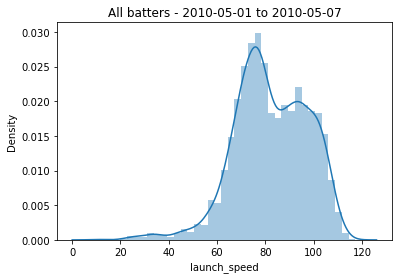

In [686]:
from matplotlib import pyplot as plt
import seaborn as sns
from pybbda.data import StatcastData

statcast_data = StatcastData()
ana_df = statcast_data.get_statcast_daily("batter", "2022-09-10", "2022-09-12")

plt.title("All batters - 2010-05-01 to 2010-05-07")

sns.distplot(ana_df.launch_speed)
plt.show()

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2657: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


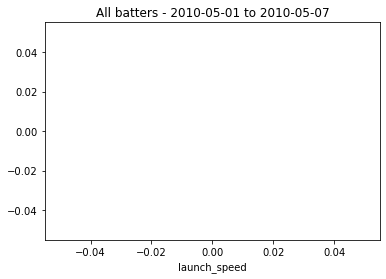

In [684]:
from matplotlib import pyplot as plt
import seaborn as sns
from pybbda.data import StatcastData

statcast_data = StatcastData()
ana_df = statcast_data.get_statcast_daily("batter", "2012-09-01", "2012-09-03")

plt.title("All batters - 2010-05-01 to 2010-05-07")

sns.distplot(ana_df.launch_speed)
plt.show()

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from pybbda.analysis.trajectories import BattedBallTrajectory

trajectory_calc = BattedBallTrajectory()

trajectories = pd.concat(
    [
        trajectory_calc.get_trajectory(
            initial_speed=a,
            launch_angle=35,
            launch_direction_angle=0,
            initial_spin=2500,
            spin_angle=-10,
        ).assign(launch_speed="ls=" + str(a))
        for a in range(10, 116, 25)
    ],
    axis=0,
)

trajectories.columns = ['time', 'horizontal', 'y_coord', 'z_coord', 'vx', 'vy', 'vz', 'launch_speed']

plt.clf()
sns.lineplot(
    data=trajectories,
    x="y_coord",
    y="z_coord",
    hue="launch_speed",
    palette=sns.cubehelix_palette(rot=-0.4)[0:5],
)
_ = plt.title("launch angle = 35")

In [27]:
import attr
from functools import lru_cache

from pybbda.analysis.simulations.components.event import (
    BattingEvent,
    FirstBaseRunningEvent,
    SecondBaseRunningEvent,
    ThirdBaseRunningEvent,
)
from pybbda.analysis.utils import check_is_zero_one
from pybbda.analysis.simulations.constants import MAX_OUTS, INNING_OUTS


@attr.s(frozen=True)
class BaseState:
    """
    A class to represent a base state. An occupied base is
    represented by a 1 and an empty base by a 0.
    """

    first_base = attr.ib(type=int, validator=check_is_zero_one)
    second_base = attr.ib(type=int, validator=check_is_zero_one)
    third_base = attr.ib(type=int, validator=check_is_zero_one)

    def __iter__(self):
        yield self.first_base
        yield self.second_base
        yield self.third_base

    def evolve(
        self,
        batting_event,
        first_base_running_event=FirstBaseRunningEvent.DEFAULT,
        second_base_running_event=SecondBaseRunningEvent.DEFAULT,
        third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
    ):

        if batting_event == BattingEvent.OUT:
            base_state = attr.evolve(self)

        elif batting_event == BattingEvent.BASE_ON_BALLS:
            base_state = BaseState(
                first_base=1,
                second_base=1 if self.first_base == 1 else self.second_base,
                third_base=1
                if self.first_base == 1 and self.second_base == 1
                else self.third_base,
            )

        elif batting_event == BattingEvent.SINGLE:

            running_events = get_running_events_cached(
                batting_event,
                first_base_running_event,
                second_base_running_event,
                third_base_running_event,
            )[0:2]

            if running_events == (
                FirstBaseRunningEvent.FIRST_TO_SECOND,
                SecondBaseRunningEvent.SECOND_TO_THIRD,
            ):
                base_state = BaseState(
                    1, 1 if self.first_base else 0, 1 if self.second_base else 0
                )

            elif running_events == (
                FirstBaseRunningEvent.FIRST_TO_SECOND,
                SecondBaseRunningEvent.SECOND_TO_HOME,
            ):
                base_state = BaseState(1, 1 if self.first_base else 0, 0)

            elif running_events == (
                FirstBaseRunningEvent.FIRST_TO_THIRD,
                SecondBaseRunningEvent.SECOND_TO_HOME,
            ):
                base_state = BaseState(1, 0, 1 if self.first_base else 0)

            elif running_events == (
                FirstBaseRunningEvent.FIRST_TO_HOME,
                SecondBaseRunningEvent.SECOND_TO_HOME,
            ):
                base_state = BaseState(1, 0, 0)

            else:
                raise ValueError(
                    "running_events combination %s is not valid", running_events
                )
        elif batting_event == BattingEvent.DOUBLE:
            running_events = get_running_events_cached(
                batting_event,
                first_base_running_event,
                second_base_running_event,
                third_base_running_event,
            )[0]

            if running_events == FirstBaseRunningEvent.FIRST_TO_THIRD:
                base_state = BaseState(0, 1, 1 if self.first_base else 0)
            elif running_events == FirstBaseRunningEvent.FIRST_TO_HOME:
                base_state = BaseState(0, 1, 0)

        elif batting_event == BattingEvent.TRIPLE:
            base_state = BaseState(0, 0, 1)
        elif batting_event == BattingEvent.HOME_RUN:
            base_state = BaseState(0, 0, 0)
        else:
            raise ValueError(
                "evolving with batting event {} "
                "and running events %{} is not valid".format(
                    batting_event,
                    (
                        first_base_running_event,
                        second_base_running_event,
                        third_base_running_event,
                    ),
                )
            )

        return attr.evolve(
            self,
            first_base=base_state.first_base,
            second_base=base_state.second_base,
            third_base=base_state.third_base,
        )


@lru_cache(maxsize=1024)
def base_state_evolve_cached(
    cls,
    batting_event,
    first_base_running_event=FirstBaseRunningEvent.DEFAULT,
    second_base_running_event=SecondBaseRunningEvent.DEFAULT,
    third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
):
    """
    A function to call the `evolve` method of a `BaseState`.
    This is identical to the `BaseState.evolve` method,
    but implemented as a function to simplify application of
    an `functools.lru_cache` decorator.
    :param cls: An instance of a `BaseState`
    :param batting_event: `BattingEvent`
    :param first_base_running_event:
    :param second_base_running_event:
    :param third_base_running_event:
    :return: `BaseState`
    """
    return cls.evolve(
        batting_event,
        first_base_running_event=first_base_running_event,
        second_base_running_event=second_base_running_event,
        third_base_running_event=third_base_running_event,
    )


@lru_cache(maxsize=8192)
def base_out_state_evolve_cached(
    cls,
    batting_event,
    first_base_running_event=FirstBaseRunningEvent.DEFAULT,
    second_base_running_event=SecondBaseRunningEvent.DEFAULT,
    third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
):
    """
    A function to call the `evolve` method of a `BaseOutState`.
    This is identical to the `BaseOutState.evolve` method,
    but implemented as a function to simplify application of
    an `functools.lru_cache` decorator.
    :param cls: An instance of a `BaseOutState`
    :param batting_event: `BattingEvent`
    :param first_base_running_event:
    :param second_base_running_event:
    :param third_base_running_event:
    :return: `BaseOutState`
    """
    return cls.evolve(
        batting_event,
        first_base_running_event=first_base_running_event,
        second_base_running_event=second_base_running_event,
        third_base_running_event=third_base_running_event,
    )


@lru_cache(maxsize=1024)
def runs_scored_cached(initial_state, end_state):
    """
    A function to call the `runs_scored` staticmethod of the `BaseOutState` class
    and apply an `functools.lru_cache`
    :param initial_state: `BaseOutState`
    :param end_state: `BaseOutState`
    :return: int
    """
    return BaseOutState.runs_scored(initial_state, end_state)


@lru_cache(maxsize=1024)
def get_running_events_cached(
    batting_event,
    first_base_running_event,
    second_base_running_event,
    third_base_running_event,
):
    """
    A function to apply the `get_running_events staticmethod of
    the `BaseOutState` class and apply an `functools.lru_cache`
    :param batting_event:
    :param first_base_running_event:
    :param second_base_running_event:
    :param third_base_running_event:
    :return: `RunEvents`
    """
    return BaseOutState.get_running_events(
        batting_event,
        first_base_running_event,
        second_base_running_event,
        third_base_running_event,
    )


@lru_cache(maxsize=1024)
def validate_running_events_cached(
    first_base_running_event, second_base_running_event, third_base_running_event
):
    """
    A function to validate that running events are self consistent, i.e. that
    if first base runner goes to third or home, it's not blocked by the
    second-base runner.
    :param first_base_running_event:
    :param second_base_running_event:
    :param third_base_running_event:
    :return: None
    :raises: `ValueError`
    """
    return BaseOutState._validate_running_events(
        first_base_running_event, second_base_running_event, third_base_running_event
    )


@attr.s(frozen=True)
class BaseOutState:
    base_state = attr.ib(type=BaseState)
    outs = attr.ib(type=int)
    max_outs = attr.ib(type=int, default=MAX_OUTS)

    @staticmethod
    def runs_scored(initial_state, end_state):
        """
        Computes the runs scored from state `initial_state` to state `end_state`.
        The computation is based on the assumption that the number of base runners
        plus the number of outs in the end state is equal to the number of base runners
        plus the number of outs in the start state plus one (the batter) minus the runs.
        :param initial_state: `BaseOutState`
        :param end_state: `BaseOutState`
        :return: int
        :raises: `ValueError` if runs scored is less than zero
        """
        # runs = -d(runners) - d(outs) + 1
        if end_state.outs % INNING_OUTS == 0 and end_state.outs > initial_state.outs:
            return 0
        if end_state.outs == MAX_OUTS:
            return 0
        runners_end = sum(end_state.base_state)
        runners_start = sum(initial_state.base_state)
        delta_runners = runners_end - runners_start
        delta_outs = end_state.outs - initial_state.outs
        if delta_runners + delta_outs > 1:
            raise ValueError(
                f"delta runners {delta_runners} "
                f"and delta outs {delta_outs} "
                f"implies runs scored is {1-delta_runners-delta_outs} which is invalid"
            )
        return 1 - delta_runners - delta_outs

    @staticmethod
    def get_running_events(
        batting_event,
        first_base_running_event,
        second_base_running_event,
        third_base_running_event,
    ):
        if batting_event == BattingEvent.SINGLE:
            running_events = (
                (
                    FirstBaseRunningEvent.FIRST_TO_SECOND
                    if first_base_running_event == FirstBaseRunningEvent.DEFAULT
                    else first_base_running_event
                ),
                (
                    SecondBaseRunningEvent.SECOND_TO_THIRD
                    if second_base_running_event == SecondBaseRunningEvent.DEFAULT
                    else second_base_running_event
                ),
                (
                    ThirdBaseRunningEvent.THIRD_TO_HOME
                    if third_base_running_event == ThirdBaseRunningEvent.DEFAULT
                    else third_base_running_event
                ),
            )
        elif batting_event == BattingEvent.DOUBLE:
            running_events = (
                (
                    FirstBaseRunningEvent.FIRST_TO_THIRD
                    if first_base_running_event == FirstBaseRunningEvent.DEFAULT
                    else first_base_running_event
                ),
                (
                    SecondBaseRunningEvent.SECOND_TO_HOME
                    if second_base_running_event == SecondBaseRunningEvent.DEFAULT
                    else second_base_running_event
                ),
                (
                    ThirdBaseRunningEvent.THIRD_TO_HOME
                    if third_base_running_event == ThirdBaseRunningEvent.DEFAULT
                    else third_base_running_event
                ),
            )
        else:
            running_events = (
                first_base_running_event,
                second_base_running_event,
                third_base_running_event,
            )
        BaseOutState._validate_running_events(*running_events)
        return running_events

    @staticmethod
    def _validate_running_events(
        first_base_running_event, second_base_running_event, third_base_running_event
    ):
        if (
            first_base_running_event == FirstBaseRunningEvent.FIRST_TO_THIRD
            or first_base_running_event == FirstBaseRunningEvent.FIRST_TO_HOME
        ) and second_base_running_event != SecondBaseRunningEvent.SECOND_TO_HOME:
            raise ValueError(
                "running events are not consistent %s",
                (
                    first_base_running_event,
                    second_base_running_event,
                    third_base_running_event,
                ),
            )

    def evolve(
        self,
        batting_event,
        first_base_running_event=FirstBaseRunningEvent.DEFAULT,
        second_base_running_event=SecondBaseRunningEvent.DEFAULT,
        third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
    ):

        outs = self.outs

        if outs == self.max_outs:
            base_state = attr.evolve(self)
        elif batting_event == BattingEvent.OUT:
            outs = self.outs + 1
            if outs % INNING_OUTS == 0:
                base_state = BaseState(0, 0, 0)
            else:
                base_state = base_state_evolve_cached(
                    self.base_state,
                    batting_event=batting_event,
                    first_base_running_event=first_base_running_event,
                    second_base_running_event=second_base_running_event,
                    third_base_running_event=third_base_running_event,
                )
        else:
            base_state = base_state_evolve_cached(
                self.base_state,
                batting_event=batting_event,
                first_base_running_event=first_base_running_event,
                second_base_running_event=second_base_running_event,
                third_base_running_event=third_base_running_event,
            )

        return attr.evolve(self, base_state=base_state, outs=outs)


@attr.s(hash=True)
class GameState:
    base_out_state = attr.ib(
        type=BaseOutState, default=BaseOutState(BaseState(0, 0, 0), 0)
    )
    pa_count = attr.ib(type=int, default=1)
    lineup_slot = attr.ib(type=int, default=1)
    score = attr.ib(type=int, default=0)

    @staticmethod
    def pa_count_to_lineup_slot(pa_count):
        return ((pa_count - 1) % 9) + 1

    def evolve(
        self,
        batting_event,
        first_base_running_event=FirstBaseRunningEvent.DEFAULT,
        second_base_running_event=SecondBaseRunningEvent.DEFAULT,
        third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
    ):
        base_out_state = base_out_state_evolve_cached(
            self.base_out_state,
            batting_event,
            first_base_running_event,
            second_base_running_event,
            third_base_running_event,
        )
        runs_scored = runs_scored_cached(self.base_out_state, base_out_state)
        game_state = attr.evolve(
            self,
            base_out_state=base_out_state,
            pa_count=self.pa_count + 1,
            lineup_slot=self.pa_count_to_lineup_slot(self.pa_count + 1),
            score=self.score + runs_scored,
        )

        return game_state

In [29]:
import itertools
class BattingEvent(Enum):
    BASE_ON_BALLS = 0
    SINGLE = 1
    DOUBLE = 2
    TRIPLE = 3
    HOME_RUN = 4
    OUT = 5

In [30]:
@attr.s(frozen=True)
class GameEvent:
    """
    Class for a `GameEvent`. A `GameEvent` is a `BattingEvent`
    a `FirstBaseRunningEvent`, a `SecondBaseRunningEvent`, and
    a `ThirdBaseRunningEvent`
    """
    batting_event = attr.ib(type=BattingEvent)
    first_base_running_event = attr.ib(
        type=FirstBaseRunningEvent, default=FirstBaseRunningEvent.DEFAULT
    )
    second_base_running_event = attr.ib(
        type=SecondBaseRunningEvent, default=SecondBaseRunningEvent.DEFAULT
    )
    third_base_running_event = attr.ib(
        type=ThirdBaseRunningEvent, default=ThirdBaseRunningEvent.DEFAULT
    )

In [31]:
@attr.s(frozen=True)
class MarkovEvent:
    """
    A MarkovEvent comprises a GameEvent and a probability for that event to occur
    :param game_event: The GameEvent
    :param probability: Probability for the GameEvent
    """
    game_event = attr.ib(type=GameEvent)
    probability = attr.ib(type=float)

In [32]:
@attr.s(frozen=True)
class MarkovEvents:
    """
    MarkovEvents comprise a list of `MarkovEvent` type
    
    :param events: List of `MarkovEvent`
    """
    events = attr.ib(type=list[MarkovEvent])
    def __iter__(self):
        for event in self.events:
            yield event
    @property
    def total_probability(self):
        """The total probability for the events to occur"""
        return sum([event.probability for event in self.events])
    @staticmethod
    def from_players(
            batter, first_base_runner=None, second_base_runner=None, third_base_runner=None
    ):
        pass
    @staticmethod
    def from_probs(batting_event_probs, running_event_probs):
        """
        Constructs a `MarkovEvents` from batting and running probabilities
        
        :param batting_event_probs: `BattingEventProbability`
        :param running_event_probs: `RunningEventProbability`
        :return: `MarkovEvents`
        .. code-block:: python
        markov_events = (
        MarkovEvents.from_probs(
        BattingEventProbability(0.08, 0.15, 0.05, 0.005, 0.03),
        RunningEventProbability(0.1, 0.1, 0.1, 0.1)
        )
        )
        
        """
        total_prob_on_singles = (
            running_event_probs.first_to_second_on_single
            + (
                running_event_probs.first_to_third_on_single
                + running_event_probs.first_to_home_on_single
            )
            * running_event_probs.second_to_home_on_single
        )
        total_prob_on_singles_inv = 1 / total_prob_on_singles
        events = [
            (
                GameEvent(
                    BattingEvent.OUT,
                    FirstBaseRunningEvent.DEFAULT,
                    SecondBaseRunningEvent.DEFAULT,
                    ThirdBaseRunningEvent.DEFAULT,
                ),
                batting_event_probs.out,
            ),
            (
                GameEvent(
                    BattingEvent.BASE_ON_BALLS,
                    FirstBaseRunningEvent.DEFAULT,
                    SecondBaseRunningEvent.DEFAULT,
                    ThirdBaseRunningEvent.DEFAULT,
                ),
                batting_event_probs.base_on_balls,
            ),
            (
                GameEvent(
                    BattingEvent.SINGLE,
                    FirstBaseRunningEvent.DEFAULT,
                    SecondBaseRunningEvent.DEFAULT,
                    ThirdBaseRunningEvent.DEFAULT,
                ),
                batting_event_probs.single
                * (
                    1
                    - running_event_probs.first_to_third_on_single
                    - running_event_probs.first_to_home_on_single
                )
                * (1 - running_event_probs.second_to_home_on_single)
                * total_prob_on_singles_inv,
            ),
            (
                GameEvent(
                    BattingEvent.SINGLE,
                    FirstBaseRunningEvent.DEFAULT,
                    SecondBaseRunningEvent.SECOND_TO_HOME,
                    ThirdBaseRunningEvent.DEFAULT,
                ),
                batting_event_probs.single
                * (
                    1
                    - running_event_probs.first_to_third_on_single
                    - running_event_probs.first_to_home_on_single
                )
                * running_event_probs.second_to_home_on_single
                * total_prob_on_singles_inv,
            ),
            (
                GameEvent(
                    BattingEvent.SINGLE,
                    FirstBaseRunningEvent.FIRST_TO_THIRD,
                    SecondBaseRunningEvent.SECOND_TO_HOME,
                    ThirdBaseRunningEvent.DEFAULT,
                ),
                batting_event_probs.single
                * running_event_probs.first_to_third_on_single
                * running_event_probs.second_to_home_on_single
                * total_prob_on_singles_inv,
            ),
            (
                GameEvent(
                    BattingEvent.SINGLE,
                    FirstBaseRunningEvent.FIRST_TO_HOME,
                    SecondBaseRunningEvent.SECOND_TO_HOME,
                    ThirdBaseRunningEvent.DEFAULT,
                ),
                batting_event_probs.single
                * running_event_probs.first_to_home_on_single
                * running_event_probs.second_to_home_on_single
                * total_prob_on_singles_inv,
            ),
            (
                GameEvent(
                    BattingEvent.DOUBLE,
                    FirstBaseRunningEvent.DEFAULT,
                    SecondBaseRunningEvent.DEFAULT,
                    ThirdBaseRunningEvent.DEFAULT,
                ),
                batting_event_probs.double
                * (1 - running_event_probs.first_to_home_on_double),
            ),
            (
                GameEvent(
                    BattingEvent.DOUBLE,
                    FirstBaseRunningEvent.FIRST_TO_HOME,
                    SecondBaseRunningEvent.DEFAULT,
                    ThirdBaseRunningEvent.DEFAULT,
                ),
                batting_event_probs.double
                * running_event_probs.first_to_home_on_double,
            ),
            (
                GameEvent(
                    BattingEvent.TRIPLE,
                    FirstBaseRunningEvent.DEFAULT,
                    SecondBaseRunningEvent.DEFAULT,
                    ThirdBaseRunningEvent.DEFAULT,
                ),
                batting_event_probs.triple,
            ),
            (
                GameEvent(
                    BattingEvent.HOME_RUN,
                    FirstBaseRunningEvent.DEFAULT,
                    SecondBaseRunningEvent.DEFAULT,
                    ThirdBaseRunningEvent.DEFAULT,
                ),
                batting_event_probs.home_run,
            ),
        ]
        return MarkovEvents([MarkovEvent(*e) for e in events])
    

In [28]:
from enum import Enum
class FirstBaseRunningEvent(Enum):
    DEFAULT = 0
    FIRST_TO_SECOND = 1
    FIRST_TO_THIRD = 2
    FIRST_TO_HOME = 3
    
class SecondBaseRunningEvent(Enum):
    DEFAULT = 0
    SECOND_TO_THIRD = 1
    SECOND_TO_HOME = 2
    
class ThirdBaseRunningEvent(Enum):
    DEFAULT = 0
    THIRD_TO_HOME = 1

In [33]:
@attr.s(frozen=True)
class BaseState:
    """
    A class to represent a base state. An occupied base is
    represented by a 1 and an empty base by a 0.
    """
    
    first_base = attr.ib(type=int)
    second_base = attr.ib(type=int)
    third_base = attr.ib(type=int)
    
    def __iter__(self):
        yield self.first_base
        yield self.second_base
        yield self.third_base
        
    def evolve(
        self,
        batting_event,
        first_base_running_event=FirstBaseRunningEvent.DEFAULT,
        second_base_running_event=SecondBaseRunningEvent.DEFAULT,
        third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
    ):

        if batting_event == BattingEvent.OUT:
            base_state = attr.evolve(self)

        elif batting_event == BattingEvent.BASE_ON_BALLS:
            base_state = BaseState(
                first_base=1,
                second_base=1 if self.first_base == 1 else self.second_base,
                third_base=1
                if self.first_base == 1 and self.second_base == 1
                else self.third_base,
            )

        elif batting_event == BattingEvent.SINGLE:

            running_events = get_running_events_cached(
                batting_event,
                first_base_running_event,
                second_base_running_event,
                third_base_running_event,
            )[0:2]

            if running_events == (
                FirstBaseRunningEvent.FIRST_TO_SECOND,
                SecondBaseRunningEvent.SECOND_TO_THIRD,
            ):
                base_state = BaseState(
                    1, 1 if self.first_base else 0, 1 if self.second_base else 0
                )

            elif running_events == (
                FirstBaseRunningEvent.FIRST_TO_SECOND,
                SecondBaseRunningEvent.SECOND_TO_HOME,
            ):
                base_state = BaseState(1, 1 if self.first_base else 0, 0)

            elif running_events == (
                FirstBaseRunningEvent.FIRST_TO_THIRD,
                SecondBaseRunningEvent.SECOND_TO_HOME,
            ):
                base_state = BaseState(1, 0, 1 if self.first_base else 0)

            elif running_events == (
                FirstBaseRunningEvent.FIRST_TO_HOME,
                SecondBaseRunningEvent.SECOND_TO_HOME,
            ):
                base_state = BaseState(1, 0, 0)
            else:
                raise ValueError(
                    "running_events combination %s is not valid", running_events
                )
        elif batting_event == BattingEvent.DOUBLE:
            running_events = get_running_events_cached(
                batting_event,
                first_base_running_event,
                second_base_running_event,
                third_base_running_event,
            )[0]
        if running_events == FirstBaseRunningEvent.FIRST_TO_THIRD:
            base_state = BaseState(0, 1, 1 if self.first_base else 0)
        elif running_events == FirstBaseRunningEvent.FIRST_TO_HOME:
            base_state = BaseState(0, 1, 0)

        elif batting_event == BattingEvent.TRIPLE:
            base_state = BaseState(0, 0, 1)
        elif batting_event == BattingEvent.HOME_RUN:
            base_state = BaseState(0, 0, 0)
        else:
            raise ValueError(
                "evolving with batting event {} "
                "and running events %{} is not valid".format(
                    batting_event,
                    (
                        first_base_running_event,
                        second_base_running_event,
                        third_base_running_event,
                    ),
                )
            )


        return attr.evolve(
            self,
            first_base=base_state.first_base,
            second_base=base_state.second_base,
            third_base=base_state.third_base,
        )

In [34]:
@attr.s(frozen=True)
class BaseOutState:
    base_state = attr.ib(type=BaseState)
    outs = attr.ib(type=int)
    max_outs = attr.ib(type=int, default=MAX_OUTS)
    
    @staticmethod
    def runs_scored(initial_state, end_state):
        """
        Computes the runs scored from state `initial_state` to state `end_state`.
        The computation is based on the assumption that the number of base runners
        plus the number of outs in the end state is equal to the number of base runners
        plus the number of outs in the start state plus one (the batter) minus the runs.
        
        :param initial_state: `BaseOutState`
        :param end_state: `BaseOutState`
        :return: int
        
        :raises: `ValueError` if runs scored is less than zero
        """
        # runs = -d(runners) - d(outs) + 1
        if end_state.outs % INNING_OUTS == 0 and end_state.outs > initial_state.outs:
            return 0
        if end_state.outs == MAX_OUTS:
            return 0
        runners_end = sum(end_state.base_state)
        runners_start = sum(initial_state.base_state)
        delta_runners = runners_end - runners_start
        delta_outs = end_state.outs - initial_state.outs
        if delta_runners + delta_outs > 1:
            raise ValueError(
                f"delta runners {delta_runners} "
                f"and delta outs {delta_outs} "
                f"implies runs scored is {1-delta_runners-delta_outs} which is invalid"
            )
            return 1 - delta_runners - delta_outs
        
        @staticmethod
        def get_running_events(
            batting_event,
            first_base_running_event,
            second_base_running_event,
            third_base_running_event,
        ):
            if batting_event == BattingEvent.SINGLE:
                running_events = (
                    (
                        FirstBaseRunningEvent.FIRST_TO_SECOND
                        if first_base_running_event == FirstBaseRunningEvent.DEFAULT
                        else first_base_running_event
                    ),
                    (
                        SecondBaseRunningEvent.SECOND_TO_THIRD
                        if second_base_running_event == SecondBaseRunningEvent.DEFAULT
                        else second_base_running_event
                    ),
                    (
                        ThirdBaseRunningEvent.THIRD_TO_HOME
                        if third_base_running_event == ThirdBaseRunningEvent.DEFAULT
                        else third_base_running_event
                    ),
                )
            elif batting_event == BattingEvent.DOUBLE:
                running_events = (
                    (
                        FirstBaseRunningEvent.FIRST_TO_THIRD
                        if first_base_running_event == FirstBaseRunningEvent.DEFAULT
                        else first_base_running_event
                    ),
                    (
                        SecondBaseRunningEvent.SECOND_TO_HOME
                        if second_base_running_event == SecondBaseRunningEvent.DEFAULT
                        else second_base_running_event
                    ),
                    (
                        ThirdBaseRunningEvent.THIRD_TO_HOME
                        if third_base_running_event == ThirdBaseRunningEvent.DEFAULT
                        else third_base_running_event
                    ),
                )
            else:
                running_events = (
                    first_base_running_event,
                    second_base_running_event,
                    third_base_running_event,
                )
                BaseOutState._validate_running_events(*running_events)
                return running_events
            @staticmethod
            def _validate_running_events(
                first_base_running_event, second_base_running_event, third_base_running_event
            ):
                if (
                    first_base_running_event == FirstBaseRunningEvent.FIRST_TO_THIRD
                    or first_base_running_event == FirstBaseRunningEvent.FIRST_TO_HOME
                ) and second_base_running_event != SecondBaseRunningEvent.SECOND_TO_HOME:
                    raise ValueError(
                        "running events are not consistent %s",
                        (
                            first_base_running_event,
                            second_base_running_event,
                            third_base_running_event,
                        ),
                    )

                    def evolve(
                        self,
                        batting_event,
                        first_base_running_event=FirstBaseRunningEvent.DEFAULT,
                        second_base_running_event=SecondBaseRunningEvent.DEFAULT,
                        third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
                    ):
                        outs = self.outs
                        if outs == self.max_outs:
                            base_state = attr.evolve(self)
                        elif batting_event == BattingEvent.OUT:
                            outs = self.outs + 1
                            if outs % INNING_OUTS == 0:
                                base_state = BaseState(0, 0, 0)
                            else:
                                base_state = base_state_evolve_cached(
                                    self.base_state,
                                    batting_event=batting_event,
                                    first_base_running_event=first_base_running_event,
                                    second_base_running_event=second_base_running_event,
                                    third_base_running_event=third_base_running_event,
                                )
                        else:
                            base_state = base_state_evolve_cached(
                                self.base_state,
                                batting_event=batting_event,
                                first_base_running_event=first_base_running_event,
                                second_base_running_event=second_base_running_event,
                                third_base_running_event=third_base_running_event,
                            )
                            return attr.evolve(self, base_state=base_state, outs=outs)


In [35]:
@attr.s(hash=True)
class GameState:
    base_out_state = attr.ib(
        type=BaseOutState, default=BaseOutState(BaseState(0, 0, 0), 0)
    )
    pa_count = attr.ib(type=int, default=1)
    lineup_slot = attr.ib(type=int, default=1)
    score = attr.ib(type=int, default=0)
    
    @staticmethod
    def pa_count_to_lineup_slot(pa_count):
        return ((pa_count - 1) % 9) + 1
    
    def evolve(
        self,
        batting_event,
        first_base_running_event=FirstBaseRunningEvent.DEFAULT,
        second_base_running_event=SecondBaseRunningEvent.DEFAULT,
        third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
    ):
        base_out_state = base_out_state_evolve_cached(
            self.base_out_state,
            batting_event,
            first_base_running_event,
            second_base_running_event,
            third_base_running_event,
        )
        runs_scored = runs_scored_cached(self.base_out_state, base_out_state)
        game_state = attr.evolve(
            self,
            base_out_state=base_out_state,
            pa_count=self.pa_count + 1,
            lineup_slot=self.pa_count_to_lineup_slot(self.pa_count + 1),
            score=self.score + runs_scored,
        )
        
        return game_state

In [36]:
@attr.s(frozen=True)
class MarkovState:
    """
    A MarkovState comprises a `GameState` and a probability for being in that state.
    :param game_state: The GameState
    :param probability: Probability for the GameState    """
    game_state = attr.ib(type=GameState)
    probability = attr.ib(type=float)
    @property
    def lineup_slot(self):
        return self.game_state.lineup_slot
    def to_df(self):
        """
        Converts the MarkovState to a Pandas DataFrame.
        :return: MarkovState as a DataFrame.
        .. code-block:: python
        markov_state = MarkovState(GameState(), 1)
        markov_state.to_df()
        first_base  second_base  third_base  outs  score  pa_count  prob
        0            0           0     0      0         1     1
        """
        return pd.DataFrame(
            {
                "first_base": [self.game_state.base_out_state.base_state.first_base],
                "second_base": [self.game_state.base_out_state.base_state.second_base],
                "third_base": [self.game_state.base_out_state.base_state.third_base],
                "outs": [self.game_state.base_out_state.outs],
                "score": [self.game_state.score],
                "pa_count": [self.game_state.pa_count],
                "prob": [self.probability],
            }
        )

In [37]:
@attr.s
class StateVector:
    """
    A StateVector comprises a List of `MarkovState` objects
    
    :param _states: List of `MarkovState`
    """
    
    _states = attr.ib(
        type=list[MarkovState],
        default=[MarkovState(game_state=GameState(), probability=1)],
    )
    
    def __iter__(self):
        for state in self.states:
            yield state
            
    @property
    def lineup_slot(self):
        return self.states[0].lineup_slot

    def to_df(self):
        """
        Converts `StateVector` object to Pandas DataFrame

        :return:

        .. code-block:: python

        state_vector = StateVector()
        state_vector.to_df()
        first_base  second_base  third_base  outs  score  pa_count  prob
        0            0           0     0      0         1     1

        """
        return pd.concat([MarkovState.to_df(state) for state in self.states], axis=0)

    @property
    def mean_score(self):
        """
        Mean score of the state vector

        :return: The mean score of the state
        """
        return sum([s.probability * s.game_state.score for s in self])

    @property
    def std_score(self):
        """
        Standard deviation of the score of the state vector

        :return: The std. dev score of the state
        """
        mean_score = self.mean_score
        mean_score2 = sum(
            [s.probability * s.game_state.score * s.game_state.score for s in self]
        )
        return np.sqrt(mean_score2 - mean_score * mean_score)
    @property
    def end_probability(self):
        """
        Proability for the state vector to be in an end state,
        example having 3 outs
        :return: Probability of being in an end state
        """
        return sum(
            [
                s.probability
                for s in self
                if s.game_state.base_out_state.outs == MAX_OUTS
            ]
        )
    @property
    def states(self):
        return self._states
    @staticmethod
    def combine_states(markov_states):
        """
        Combines a list of `MarkovState`.
        It deduplicates states and sums the probabilities.
        :param markov_states: List of `MarkovState`
        :return: `StateVector`
        .. code-block:: python
        m1 = MarkovState(GameState(), 0.2)
        m2 = MarkovState(GameState(), 0.25)
        StateVector.combine_states((m1, m2))
        """
        def _update(acc, item):
            acc[item.game_state] += item.probability
            return acc

        return StateVector(
            [
                MarkovState(*e)
                for e in reduce(_update, markov_states, defaultdict(float)).items()
            ]
        )

In [40]:
@attr.s 
class MarkovSimulation:
    """
    A class for executing a Markov simulation by executing state transitions to an
    initial StateVector until a threshold of probability for being in the end state
    is crossed. The simulation is executed by calling the `Markovsimulation` object.

    :param state_vector: The intial `StateVector`
    :param termination_threshold: Termination threshold. Simulation will stop when
    probability to be in the end state is larger than `1 - termination_threshold`
    """

    state_vector = attr.ib(
        type=StateVector, default=StateVector([MarkovState(GameState(), 1)])
    )
    # TODO: use runner specific values, not a single value
    running_event_probabilities = attr.ib(
        type=RunningEventProbability, default=RunningEventProbability()
    )
    termination_threshold = attr.ib(type=float, default=1e-6)

    def __call__(self, lineup, running_event_probabilities=None):
        """
        Executes the MarkovSimulation
        :param batting_event_probs: A BattingEventProbability object
        :param running_event_probs: A RunningEventProbability object
        :return: List of StateVector

        .. code-block:: python

        markov_simulation = MarkovSimulation()
        batting_event_probability = BattingEventProbability(
        0.08, 0.15, 0.05, 0.005, 0.03)
        running_event_probability = RunningEventProbability(0.1, 0.1, 0.1, 0.1)
        results = markov_simulation(batting_event_probability,
        running_event_probability)
        """
        running_event_probabilities = (
            self.running_event_probabilities
            if running_event_probabilities is None
            else running_event_probabilities
        )
        ncall = 0
        MAX_CALL = 100
        state_vector = self.state_vector
        results = [state_vector]
        while (
            ncall < MAX_CALL
            and state_vector.end_probability < 1 - self.termination_threshold
        ):
            lineup_slot = state_vector.lineup_slot
            batting_event_probs = lineup.get_batting_probs(lineup_slot)
            running_event_probs = running_event_probabilities

            markov_events = MarkovEvents.from_probs(
                batting_event_probs, running_event_probs
            )

            state_vector = self.markov_step(state_vector, markov_events)
            results.append(state_vector)
            ncall += 1
            if ncall >= MAX_CALL:
                approx_error = results[-1].mean_score - results[-2].mean_score
                # TODO: compute error based on second derivative
                logger.warning(
                    "ncall exceed max call. end_state probability is %.3e. "
                    "approximate error is %.3e",
                    state_vector.end_probability,
                    approx_error,
                )

                return results

    @staticmethod
    def state_vectors_to_df(state_vectors):
        """
        Converts list of `StateVector` to Pandas DataFrame

        :param state_vectors: List of `StateVector`
        :return: Pandas DataFrame

        .. code-block:: python

        markov_simulation = MarkovSimulation()
        batting_event_probability = BattingEventProbability(0.08, 0.15, 0.05, 0.005, 0.03)
        running_event_probability = RunningEventProbability(0.1, 0.1, 0.1, 0.1)
        results = markov_simulation(batting_event_probability, running_event_probability)
        sim_df = MarkovSimulation.state_vectors_to_df(results)
        sim_df
        first_base  second_base  third_base  outs  score  pa_count          prob
        0            0           0     0      0         1  1.000000e+00
        0            0           0     1      0         2  6.850000e-01
        1            0           0     0      0         2  2.300000e-01
        0            1           0     0      0         2  5.000000e-02
        0            0           1     0      0         2  5.000000e-03
        ...          ...         ...   ...    ...       ...           ...
        1            0           0     0     17        19  8.443152e-11
        0            1           1     0     16        19  9.725439e-11
        0            1           0     0     17        19  5.074142e-11
        0            0           1     0     17        19  1.479958e-11
        0            0           0     0     18        19  8.879749e-11

        """
        return pd.concat(
            [state_vector.to_df() for state_vector in state_vectors], axis=0
        )

    @staticmethod
    def state_transition(markov_state, markov_event):
        """
        Transition from `markov_state` based on `markov_event`

        :param markov_state: `MarkovState`
        :param markov_event: `MarkovEvent`
        :return: `MarkovState`
        """
        return MarkovState(
            base_out_state_evolve_cached(
                markov_state.game_state,
                markov_event.game_event.batting_event,
                markov_event.game_event.first_base_running_event,
                markov_event.game_event.second_base_running_event,
                markov_event.game_event.third_base_running_event,
            ),
            markov_state.probability * markov_event.probability,
        )

    @staticmethod
    def state_transition_tuple(markov_state_event):
        """
        MarkovState expressed as a tuple. This is a helper to be able to apply `map`
        to a set of transitions.

        :param markov_state_event:
        :return:
        """
        return MarkovSimulation.state_transition(*markov_state_event)

    @staticmethod
    def markov_step(state_vector, markov_events):
        """
        A step in the Markov simulation. Applies the set of `markov_events` to the
        `MarkovState` in the `state_vector`, and then combines the results
        into a `StateVector`

        :param state_vector:
        :param markov_events:

        :return: `StateVector`
        """
        return StateVector.combine_states(
            map(
                MarkovSimulation.state_transition_tuple,
                itertools.product(state_vector, markov_events),
            )
        )


In [41]:
import attr
from functools import lru_cache

from pybbda.analysis.simulations.components.event import (
    BattingEvent,
    FirstBaseRunningEvent,
    SecondBaseRunningEvent,
    ThirdBaseRunningEvent,
)
from pybbda.analysis.utils import check_is_zero_one
from pybbda.analysis.simulations.constants import MAX_OUTS, INNING_OUTS


@attr.s(frozen=True)
class BaseState:
    """
    A class to represent a base state. An occupied base is
    represented by a 1 and an empty base by a 0.
    """

    first_base = attr.ib(type=int, validator=check_is_zero_one)
    second_base = attr.ib(type=int, validator=check_is_zero_one)
    third_base = attr.ib(type=int, validator=check_is_zero_one)

    def __iter__(self):
        yield self.first_base
        yield self.second_base
        yield self.third_base

    def evolve(
        self,
        batting_event,
        first_base_running_event=FirstBaseRunningEvent.DEFAULT,
        second_base_running_event=SecondBaseRunningEvent.DEFAULT,
        third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
    ):

        if batting_event == BattingEvent.OUT:
            base_state = attr.evolve(self)

        elif batting_event == BattingEvent.BASE_ON_BALLS:
            base_state = BaseState(
                first_base=1,
                second_base=1 if self.first_base == 1 else self.second_base,
                third_base=1
                if self.first_base == 1 and self.second_base == 1
                else self.third_base,
            )

        elif batting_event == BattingEvent.SINGLE:

            running_events = get_running_events_cached(
                batting_event,
                first_base_running_event,
                second_base_running_event,
                third_base_running_event,
            )[0:2]

            if running_events == (
                FirstBaseRunningEvent.FIRST_TO_SECOND,
                SecondBaseRunningEvent.SECOND_TO_THIRD,
            ):
                base_state = BaseState(
                    1, 1 if self.first_base else 0, 1 if self.second_base else 0
                )

            elif running_events == (
                FirstBaseRunningEvent.FIRST_TO_SECOND,
                SecondBaseRunningEvent.SECOND_TO_HOME,
            ):
                base_state = BaseState(1, 1 if self.first_base else 0, 0)

            elif running_events == (
                FirstBaseRunningEvent.FIRST_TO_THIRD,
                SecondBaseRunningEvent.SECOND_TO_HOME,
            ):
                base_state = BaseState(1, 0, 1 if self.first_base else 0)

            elif running_events == (
                FirstBaseRunningEvent.FIRST_TO_HOME,
                SecondBaseRunningEvent.SECOND_TO_HOME,
            ):
                base_state = BaseState(1, 0, 0)

            else:
                raise ValueError(
                    "running_events combination %s is not valid", running_events
                )
        elif batting_event == BattingEvent.DOUBLE:
            running_events = get_running_events_cached(
                batting_event,
                first_base_running_event,
                second_base_running_event,
                third_base_running_event,
            )[0]

            if running_events == FirstBaseRunningEvent.FIRST_TO_THIRD:
                base_state = BaseState(0, 1, 1 if self.first_base else 0)
            elif running_events == FirstBaseRunningEvent.FIRST_TO_HOME:
                base_state = BaseState(0, 1, 0)

        elif batting_event == BattingEvent.TRIPLE:
            base_state = BaseState(0, 0, 1)
        elif batting_event == BattingEvent.HOME_RUN:
            base_state = BaseState(0, 0, 0)
        else:
            raise ValueError(
                "evolving with batting event {} "
                "and running events %{} is not valid".format(
                    batting_event,
                    (
                        first_base_running_event,
                        second_base_running_event,
                        third_base_running_event,
                    ),
                )
            )

        return attr.evolve(
            self,
            first_base=base_state.first_base,
            second_base=base_state.second_base,
            third_base=base_state.third_base,
        )


@lru_cache(maxsize=1024)
def base_state_evolve_cached(
    cls,
    batting_event,
    first_base_running_event=FirstBaseRunningEvent.DEFAULT,
    second_base_running_event=SecondBaseRunningEvent.DEFAULT,
    third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
):
    """
    A function to call the `evolve` method of a `BaseState`.
    This is identical to the `BaseState.evolve` method,
    but implemented as a function to simplify application of
    an `functools.lru_cache` decorator.
    :param cls: An instance of a `BaseState`
    :param batting_event: `BattingEvent`
    :param first_base_running_event:
    :param second_base_running_event:
    :param third_base_running_event:
    :return: `BaseState`
    """
    return cls.evolve(
        batting_event,
        first_base_running_event=first_base_running_event,
        second_base_running_event=second_base_running_event,
        third_base_running_event=third_base_running_event,
    )


@lru_cache(maxsize=8192)
def base_out_state_evolve_cached(
    cls,
    batting_event,
    first_base_running_event=FirstBaseRunningEvent.DEFAULT,
    second_base_running_event=SecondBaseRunningEvent.DEFAULT,
    third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
):
    """
    A function to call the `evolve` method of a `BaseOutState`.
    This is identical to the `BaseOutState.evolve` method,
    but implemented as a function to simplify application of
    an `functools.lru_cache` decorator.
    :param cls: An instance of a `BaseOutState`
    :param batting_event: `BattingEvent`
    :param first_base_running_event:
    :param second_base_running_event:
    :param third_base_running_event:
    :return: `BaseOutState`
    """
    return cls.evolve(
        batting_event,
        first_base_running_event=first_base_running_event,
        second_base_running_event=second_base_running_event,
        third_base_running_event=third_base_running_event,
    )


@lru_cache(maxsize=1024)
def runs_scored_cached(initial_state, end_state):
    """
    A function to call the `runs_scored` staticmethod of the `BaseOutState` class
    and apply an `functools.lru_cache`
    :param initial_state: `BaseOutState`
    :param end_state: `BaseOutState`
    :return: int
    """
    return BaseOutState.runs_scored(initial_state, end_state)


@lru_cache(maxsize=1024)
def get_running_events_cached(
    batting_event,
    first_base_running_event,
    second_base_running_event,
    third_base_running_event,
):
    """
    A function to apply the `get_running_events staticmethod of
    the `BaseOutState` class and apply an `functools.lru_cache`
    :param batting_event:
    :param first_base_running_event:
    :param second_base_running_event:
    :param third_base_running_event:
    :return: `RunEvents`
    """
    return BaseOutState.get_running_events(
        batting_event,
        first_base_running_event,
        second_base_running_event,
        third_base_running_event,
    )


@lru_cache(maxsize=1024)
def validate_running_events_cached(
    first_base_running_event, second_base_running_event, third_base_running_event
):
    """
    A function to validate that running events are self consistent, i.e. that
    if first base runner goes to third or home, it's not blocked by the
    second-base runner.
    :param first_base_running_event:
    :param second_base_running_event:
    :param third_base_running_event:
    :return: None
    :raises: `ValueError`
    """
    return BaseOutState._validate_running_events(
        first_base_running_event, second_base_running_event, third_base_running_event
    )


@attr.s(frozen=True)
class BaseOutState:
    base_state = attr.ib(type=BaseState)
    outs = attr.ib(type=int)
    max_outs = attr.ib(type=int, default=MAX_OUTS)

    @staticmethod
    def runs_scored(initial_state, end_state):
        """
        Computes the runs scored from state `initial_state` to state `end_state`.
        The computation is based on the assumption that the number of base runners
        plus the number of outs in the end state is equal to the number of base runners
        plus the number of outs in the start state plus one (the batter) minus the runs.
        :param initial_state: `BaseOutState`
        :param end_state: `BaseOutState`
        :return: int
        :raises: `ValueError` if runs scored is less than zero
        """
        # runs = -d(runners) - d(outs) + 1
        if end_state.outs % INNING_OUTS == 0 and end_state.outs > initial_state.outs:
            return 0
        if end_state.outs == MAX_OUTS:
            return 0
        runners_end = sum(end_state.base_state)
        runners_start = sum(initial_state.base_state)
        delta_runners = runners_end - runners_start
        delta_outs = end_state.outs - initial_state.outs
        if delta_runners + delta_outs > 1:
            raise ValueError(
                f"delta runners {delta_runners} "
                f"and delta outs {delta_outs} "
                f"implies runs scored is {1-delta_runners-delta_outs} which is invalid"
            )
        return 1 - delta_runners - delta_outs

    @staticmethod
    def get_running_events(
        batting_event,
        first_base_running_event,
        second_base_running_event,
        third_base_running_event,
    ):
        if batting_event == BattingEvent.SINGLE:
            running_events = (
                (
                    FirstBaseRunningEvent.FIRST_TO_SECOND
                    if first_base_running_event == FirstBaseRunningEvent.DEFAULT
                    else first_base_running_event
                ),
                (
                    SecondBaseRunningEvent.SECOND_TO_THIRD
                    if second_base_running_event == SecondBaseRunningEvent.DEFAULT
                    else second_base_running_event
                ),
                (
                    ThirdBaseRunningEvent.THIRD_TO_HOME
                    if third_base_running_event == ThirdBaseRunningEvent.DEFAULT
                    else third_base_running_event
                ),
            )
        elif batting_event == BattingEvent.DOUBLE:
            running_events = (
                (
                    FirstBaseRunningEvent.FIRST_TO_THIRD
                    if first_base_running_event == FirstBaseRunningEvent.DEFAULT
                    else first_base_running_event
                ),
                (
                    SecondBaseRunningEvent.SECOND_TO_HOME
                    if second_base_running_event == SecondBaseRunningEvent.DEFAULT
                    else second_base_running_event
                ),
                (
                    ThirdBaseRunningEvent.THIRD_TO_HOME
                    if third_base_running_event == ThirdBaseRunningEvent.DEFAULT
                    else third_base_running_event
                ),
            )
        else:
            running_events = (
                first_base_running_event,
                second_base_running_event,
                third_base_running_event,
            )
        BaseOutState._validate_running_events(*running_events)
        return running_events

    @staticmethod
    def _validate_running_events(
        first_base_running_event, second_base_running_event, third_base_running_event
    ):
        if (
            first_base_running_event == FirstBaseRunningEvent.FIRST_TO_THIRD
            or first_base_running_event == FirstBaseRunningEvent.FIRST_TO_HOME
        ) and second_base_running_event != SecondBaseRunningEvent.SECOND_TO_HOME:
            raise ValueError(
                "running events are not consistent %s",
                (
                    first_base_running_event,
                    second_base_running_event,
                    third_base_running_event,
                ),
            )

    def evolve(
        self,
        batting_event,
        first_base_running_event=FirstBaseRunningEvent.DEFAULT,
        second_base_running_event=SecondBaseRunningEvent.DEFAULT,
        third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
    ):

        outs = self.outs

        if outs == self.max_outs:
            base_state = attr.evolve(self)
        elif batting_event == BattingEvent.OUT:
            outs = self.outs + 1
            if outs % INNING_OUTS == 0:
                base_state = BaseState(0, 0, 0)
            else:
                base_state = base_state_evolve_cached(
                    self.base_state,
                    batting_event=batting_event,
                    first_base_running_event=first_base_running_event,
                    second_base_running_event=second_base_running_event,
                    third_base_running_event=third_base_running_event,
                )
        else:
            base_state = base_state_evolve_cached(
                self.base_state,
                batting_event=batting_event,
                first_base_running_event=first_base_running_event,
                second_base_running_event=second_base_running_event,
                third_base_running_event=third_base_running_event,
            )

        return attr.evolve(self, base_state=base_state, outs=outs)


@attr.s(hash=True)
class GameState:
    base_out_state = attr.ib(
        type=BaseOutState, default=BaseOutState(BaseState(0, 0, 0), 0)
    )
    pa_count = attr.ib(type=int, default=1)
    lineup_slot = attr.ib(type=int, default=1)
    score = attr.ib(type=int, default=0)

    @staticmethod
    def pa_count_to_lineup_slot(pa_count):
        return ((pa_count - 1) % 9) + 1

    def evolve(
        self,
        batting_event,
        first_base_running_event=FirstBaseRunningEvent.DEFAULT,
        second_base_running_event=SecondBaseRunningEvent.DEFAULT,
        third_base_running_event=ThirdBaseRunningEvent.DEFAULT,
    ):
        base_out_state = base_out_state_evolve_cached(
            self.base_out_state,
            batting_event,
            first_base_running_event,
            second_base_running_event,
            third_base_running_event,
        )
        runs_scored = runs_scored_cached(self.base_out_state, base_out_state)
        game_state = attr.evolve(
            self,
            base_out_state=base_out_state,
            pa_count=self.pa_count + 1,
            lineup_slot=self.pa_count_to_lineup_slot(self.pa_count + 1),
            score=self.score + runs_scored,
        )

        return game_state

In [42]:
MarkovSimulation()

MarkovSimulation(state_vector=StateVector(_states=[MarkovState(game_state=GameState(base_out_state=BaseOutState(base_state=BaseState(first_base=0, second_base=0, third_base=0), outs=0, max_outs=3), pa_count=1, lineup_slot=1, score=0), probability=1)]), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6), termination_threshold=1e-06)

In [43]:
import numpy as np

from pybbda.analysis.run_expectancy import MarkovSimulation
from pybbda.analysis.simulations import (
    BattingEventProbability,
    RunningEventProbability,
    Batter,
    Lineup,
    PlayerRegistry,
)

from pybbda.analysis.simulations.components.event import (
    _DEFAULT_RUNNING_EVENT_PROBS as DEFAULT_RUNNING_EVENT_PROBS,
)
from pybbda.analysis.simulations.constants import MAX_OUTS


def summarise_result(result):
    mean_score = result[-1].mean_score
    std_dev_score = result[-1].std_score
    print(
        "mean score per 27 outs = {:.4f}\n"
        "std. score per 27 outs = {:.4f}".format(
            mean_score / MAX_OUTS * 27, std_dev_score * np.sqrt(27 / MAX_OUTS)
        )
    )


def initialize_lineup():
    default_batting_probs = {
        "base_on_balls": 0.08,
        "single": 0.15,
        "double": 0.05,
        "triple": 0.005,
        "home_run": 0.03,
    }

    default_batter = Batter(
        player_id="default",
        batting_event_probabilities=BattingEventProbability(**default_batting_probs),
    )
    lineup = Lineup(lineup=[default_batter] * 9)
    return lineup


def update_lineup(lineup, lineup_slot, batter):
    lineup.set_lineup_slot(lineup_slot, batter)
    return lineup


player_registry = PlayerRegistry()
player_registry.load_from_lahman()


running_event_probs = RunningEventProbability(*DEFAULT_RUNNING_EVENT_PROBS)
print("## default running probs:\n", running_event_probs, "\n")


markov_simulation = MarkovSimulation(state_vector=StateVector(states=[MarkovState(game_state=GameState(base_out_state=BaseOutState(base_state=BaseState(first_base=1, second_base=1, third_base=1), outs=0, max_outs=3), pa_count=1, lineup_slot=6, score=1), probability=1)]), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6), termination_threshold=1e-06)


lineup = initialize_lineup()
result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result")
summarise_result(result)


lahman_id = "henderi01_1982"
lineup = update_lineup(lineup, 1, player_registry.registry[lahman_id])
result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result")
summarise_result(result)

## default running probs:
 RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6) 

## markov simulation result
mean score per 27 outs = 27.6507
std. score per 27 outs = 5.9589
## markov simulation result
mean score per 27 outs = 27.6526
std. score per 27 outs = 5.9611


In [39]:
import numpy as np

from pybbda.analysis.run_expectancy import MarkovSimulation
from pybbda.analysis.simulations import (
    BattingEventProbability,
    RunningEventProbability,
    Batter,
    Lineup,
    PlayerRegistry,
)

from pybbda.analysis.simulations.components.event import (
    _DEFAULT_RUNNING_EVENT_PROBS as DEFAULT_RUNNING_EVENT_PROBS,
)
from pybbda.analysis.simulations.constants import MAX_OUTS


def summarise_result(result):
    mean_score = result[-1].mean_score
    std_dev_score = result[-1].std_score
    print(
        "mean score per 27 outs = {:.4f}\n"
        "std. score per 27 outs = {:.4f}".format(
            mean_score / MAX_OUTS * 27, std_dev_score * np.sqrt(27 / MAX_OUTS)
        )
    )


def initialize_lineup():
    default_batting_probs = {
        "base_on_balls": 0.08,
        "single": 0.15,
        "double": 0.05,
        "triple": 0.005,
        "home_run": 0.03,
    }

    default_batter = Batter(
        player_id="default",
        batting_event_probabilities=BattingEventProbability(**default_batting_probs),
    )
    lineup = Lineup(lineup=[default_batter] * 9)
    return lineup


def update_lineup(lineup, lineup_slot, batter):
    lineup.set_lineup_slot(lineup_slot, batter)
    return lineup



In [44]:
res4 = cur.execute("SELECT playerID, yearID, SUM(salary) AS totalSalary FROM Salaries GROUP BY playerID HAVING totalSalary > 140000000")
res4.fetchall()

[('bondsba01', 1986, 188245322.0),
 ('delgaca01', 1994, 146299000.0),
 ('griffke02', 1989, 151703682.0),
 ('jeterde01', 1996, 205430000.0),
 ('johnsra05', 1989, 175550019.0),
 ('jonesch06', 1993, 141552133.0),
 ('maddugr01', 1988, 153845000.0),
 ('martipe02', 1993, 146259585.0),
 ('mussimi01', 1991, 144533619.0),
 ('ramirma02', 1993, 204807769.0),
 ('rodrial01', 1994, 264416252.0),
 ('sheffga01', 1989, 168008550.0)]

In [45]:
res5 = cur.execute("SELECT playerID, SUM(W) AS totalPlayoffWins FROM PitchingPost GROUP BY playerID HAVING totalPlayoffWins > 6 AND round = 'WS' ORDER BY totalPlayoffWins DESC")
res5.fetchall()

[('schilcu01', 11),
 ('stewada01', 10),
 ('fordwh01', 10),
 ('hunteca01', 9),
 ('hernaor01', 9),
 ('palmeji01', 8),
 ('coneda01', 8),
 ('ruffire01', 7),
 ('reynoal01', 7),
 ('morrija02', 7),
 ('leecl02', 7),
 ('gibsobo01', 7),
 ('carutbo01', 7)]

In [46]:
res6 = cur.execute("SELECT nameLast, nameFirst, yearID, AVG(ERA) as meanERA, SUM(IPOuts) as sumOuts FROM Master NATURAL JOIN Pitching GROUP BY playerID HAVING meanERA <= 1.25 AND sumOuts > 50 ORDER BY meanERA DESC LIMIT 10")
res6.fetchall()

[('Tedrow', 'Al', 1914, 1.21, 67),
 ('Howard', 'Chris', 1993, 1.21, 138),
 ('Sisler', 'George', 1915, 1.19, 333),
 ('Winham', 'Lave', 1902, 1.125, 117),
 ('Herbert', 'Fred', 1915, 1.06, 51),
 ('Tipple', 'Dan', 1915, 0.95, 57),
 ('Hafford', 'Leo', 1906, 0.95, 57),
 ('Frieri', 'Ernesto', 2009, 0.855, 101),
 ('Foxx', 'Jimmie', 1939, 0.795, 71),
 ('Jansen', 'Kenley', 2010, 0.67, 81)]

In [47]:
{k: v for k, v in player_registry.registry.items() if v.batting_event_probabilities.base_on_balls > .23}

{'bishoma01_1934': Batter(player_id='bishoma01_1934', batting_event_probabilities=BattingEventProbability(base_on_balls=0.2404692082111437, single=0.1495601173020528, double=0.03812316715542522, triple=0.002932551319648094, home_run=0.002932551319648094), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'bondsba01_2001': Batter(player_id='bondsba01_2001', batting_event_probabilities=BattingEventProbability(base_on_balls=0.26656626506024095, single=0.07379518072289157, double=0.04819277108433735, triple=0.0030120481927710845, home_run=0.10993975903614457), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'bondsba01_2002': Batter(player_id='bondsba01_2002', batting_event_probabilities=BattingEventProbability(base_on_balls=0.32352941176470

In [48]:
player_registry = PlayerRegistry()
player_registry.load_from_lahman()

running_event_probs = RunningEventProbability(*DEFAULT_RUNNING_EVENT_PROBS)
print("## default running probs:\n", running_event_probs, "\n")


markov_simulation = MarkovSimulation(termination_threshold=1e-4)


lineup = initialize_lineup()
result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for default game")
summarise_result(result)


lineup = update_lineup(lineup, 1, player_registry.registry["bondsba01_2001"])
lineup = update_lineup(lineup, 2, player_registry.registry["dietzdi01_1973"])
lineup = update_lineup(lineup, 3, player_registry.registry["willite01_1954"])
lineup = update_lineup(lineup, 4, player_registry.registry["fainfe01_1955"])
lineup = update_lineup(lineup, 5, player_registry.registry["bishoma01_1934"])
lineup = update_lineup(lineup, 6, player_registry.registry["ruthba01_1923"])
lineup = update_lineup(lineup, 7, player_registry.registry["robinya01_1890"])
lineup = update_lineup(lineup, 8, player_registry.registry["mcgrajo01_1899"])
lineup = update_lineup(lineup, 9, player_registry.registry["grandya01_2021"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for filtration game")
summarise_result(result)

## default running probs:
 RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6) 

## markov simulation result for default game
mean score per 27 outs = 4.2242
std. score per 27 outs = 3.0161
## markov simulation result for filtration game
mean score per 27 outs = 10.7012
std. score per 27 outs = 5.5100


In [49]:
{k: v for k, v in player_registry.registry.items() if v.batting_event_probabilities.home_run > .085}

{'aaronha01_1973': Batter(player_id='aaronha01_1973', batting_event_probabilities=BattingEventProbability(base_on_balls=0.14623655913978495, single=0.13978494623655913, double=0.025806451612903226, triple=0.002150537634408602, home_run=0.08602150537634409), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'bondsba01_2001': Batter(player_id='bondsba01_2001', batting_event_probabilities=BattingEventProbability(base_on_balls=0.26656626506024095, single=0.07379518072289157, double=0.04819277108433735, triple=0.0030120481927710845, home_run=0.10993975903614457), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'garvemi01_2019': Batter(player_id='garvemi01_2019', batting_event_probabilities=BattingEventProbability(base_on_balls=0.114206128133

In [50]:
player_registry = PlayerRegistry()
player_registry.load_from_lahman()

running_event_probs = RunningEventProbability(*DEFAULT_RUNNING_EVENT_PROBS)
print("## default running probs:\n", running_event_probs, "\n")

markov_simulation = MarkovSimulation(termination_threshold=1e-4)

lineup = initialize_lineup()
result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for default game")
summarise_result(result)


lineup = update_lineup(lineup, 1, player_registry.registry["bondsba01_2001"])
lineup = update_lineup(lineup, 2, player_registry.registry["martijd02_2017"])
lineup = update_lineup(lineup, 3, player_registry.registry["mcgwima01_1995"])
lineup = update_lineup(lineup, 4, player_registry.registry["voitlu01_2020"])
lineup = update_lineup(lineup, 5, player_registry.registry["sosasa01_2001"])
lineup = update_lineup(lineup, 6, player_registry.registry["olsonma02_2017"])
lineup = update_lineup(lineup, 7, player_registry.registry["ruthba01_1920"])
lineup = update_lineup(lineup, 8, player_registry.registry["zuninmi01_2021"])
lineup = update_lineup(lineup, 9, player_registry.registry["willima04_1994"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for filtration game")
summarise_result(result)

## default running probs:
 RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6) 

## markov simulation result for default game
mean score per 27 outs = 4.2242
std. score per 27 outs = 3.0161
## markov simulation result for filtration game
mean score per 27 outs = 9.7030
std. score per 27 outs = 4.7298


In [51]:
{k: v for k, v in player_registry.registry.items() if (v.batting_event_probabilities.home_run < .01) & (v.batting_event_probabilities.base_on_balls < .01)& (v.batting_event_probabilities.base_on_balls < .01) & (v.batting_event_probabilities.single < .15)}

{'cassijo01_1875': Batter(player_id='cassijo01_1875', batting_event_probabilities=BattingEventProbability(base_on_balls=0.0, single=0.13297872340425532, double=0.02127659574468085, triple=0.010638297872340425, home_run=0.005319148936170213), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'dailyed01_1885': Batter(player_id='dailyed01_1885', batting_event_probabilities=BattingEventProbability(base_on_balls=0.0, single=0.14673913043478262, double=0.043478260869565216, triple=0.010869565217391304, home_run=0.005434782608695652), running_event_probabilities=RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6)),
 'gerhajo01_1879': Batter(player_id='gerhajo01_1879', batting_event_probabilities=BattingEventProbability(base_on_balls=0.00949367088607595, single=0.145569620253164

In [52]:
player_registry = PlayerRegistry()
player_registry.load_from_lahman()

running_event_probs = RunningEventProbability(*DEFAULT_RUNNING_EVENT_PROBS)
print("## default running probs:\n", running_event_probs, "\n")


markov_simulation = MarkovSimulation(termination_threshold=1e-4)


lineup = initialize_lineup()
result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for default game")
summarise_result(result)


lineup = update_lineup(lineup, 1, player_registry.registry["weyhigu01_1888"])
lineup = update_lineup(lineup, 2, player_registry.registry["snydere01_1876"])
lineup = update_lineup(lineup, 3, player_registry.registry["rosemch01_1882"])
lineup = update_lineup(lineup, 4, player_registry.registry["powerdo01_1906"])
lineup = update_lineup(lineup, 5, player_registry.registry["mcgeaja01_1886"])
lineup = update_lineup(lineup, 6, player_registry.registry["johnsre02_2014"])
lineup = update_lineup(lineup, 7, player_registry.registry["hackeme01_1884"])
lineup = update_lineup(lineup, 8, player_registry.registry["gerhajo01_1879"])
lineup = update_lineup(lineup, 9, player_registry.registry["cassijo01_1875"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for filtration game")
summarise_result(result)

## default running probs:
 RunningEventProbability(first_to_third_on_single=0.26, first_to_home_on_single=0.01, first_to_home_on_double=0.41, second_to_home_on_single=0.6) 

## markov simulation result for default game
mean score per 27 outs = 4.2242
std. score per 27 outs = 3.0161
## markov simulation result for filtration game
mean score per 27 outs = 1.2102
std. score per 27 outs = 1.4600


In [53]:
lahman_data.batting.loc[(lahman_data.batting.yearID == 2008) & (lahman_data.batting.teamID == "PHI") & (lahman_data.batting.G > 100)]

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
90255,brunter01,2008,1,PHI,NL,120,212,37,46,9,...,15.0,9.0,2.0,21,35.0,3.0,3.0,2.0,0.0,7.0
90272,burrepa01,2008,1,PHI,NL,157,536,74,134,33,...,86.0,0.0,0.0,102,136.0,8.0,1.0,0.0,6.0,10.0
90426,dobbsgr01,2008,1,PHI,NL,128,226,30,68,14,...,40.0,3.0,1.0,11,40.0,1.0,1.0,0.0,2.0,4.0
90487,felizpe01,2008,1,PHI,NL,133,425,43,106,19,...,58.0,0.0,0.0,33,54.0,3.0,0.0,3.0,2.0,14.0
90677,howarry01,2008,1,PHI,NL,162,610,105,153,26,...,146.0,1.0,1.0,81,199.0,17.0,3.0,0.0,6.0,11.0
90714,jenkige01,2008,1,PHI,NL,115,293,27,72,16,...,29.0,1.0,1.0,24,68.0,5.0,1.0,0.0,4.0,6.0
91182,rolliji01,2008,1,PHI,NL,137,556,76,154,38,...,59.0,47.0,3.0,58,55.0,7.0,5.0,3.0,3.0,11.0
91196,ruizca01,2008,1,PHI,NL,117,320,47,70,14,...,31.0,1.0,2.0,44,38.0,6.0,4.0,4.0,1.0,14.0
91374,utleych01,2008,1,PHI,NL,159,607,113,177,41,...,104.0,14.0,2.0,64,104.0,14.0,27.0,1.0,8.0,9.0
91393,victosh01,2008,1,PHI,NL,146,570,102,167,30,...,58.0,36.0,11.0,45,69.0,2.0,7.0,5.0,0.0,8.0


In [54]:
lineup = update_lineup(lineup, 1, player_registry.registry["brunter01_2008"])
lineup = update_lineup(lineup, 2, player_registry.registry["burrepa01_2008"])
lineup = update_lineup(lineup, 3, player_registry.registry["victosh01_2008"])
lineup = update_lineup(lineup, 4, player_registry.registry["felizpe01_2008"])
lineup = update_lineup(lineup, 5, player_registry.registry["howarry01_2008"])
lineup = update_lineup(lineup, 6, player_registry.registry["werthja01_2008"])
lineup = update_lineup(lineup, 7, player_registry.registry["rolliji01_2008"])
lineup = update_lineup(lineup, 8, player_registry.registry["ruizca01_2008"])
lineup = update_lineup(lineup, 9, player_registry.registry["utleych01_2008"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for filtration game")
summarise_result(result)

## markov simulation result for filtration game
mean score per 27 outs = 4.6023
std. score per 27 outs = 3.2490


In [55]:
lineup = update_lineup(lineup, 1, player_registry.registry["bohmal01_2021"])
lineup = update_lineup(lineup, 2, player_registry.registry["gregodi01_2021"])
lineup = update_lineup(lineup, 3, player_registry.registry["harpebr03_2021"])
lineup = update_lineup(lineup, 4, player_registry.registry["herreod01_2021"])
lineup = update_lineup(lineup, 5, player_registry.registry["hoskirh01_2021"])
lineup = update_lineup(lineup, 6, player_registry.registry["mccutan01_2021"])
lineup = update_lineup(lineup, 7, player_registry.registry["millebr02_2021"])
lineup = update_lineup(lineup, 8, player_registry.registry["realmjt01_2021"])
lineup = update_lineup(lineup, 9, player_registry.registry["segurje01_2021"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for filtration game")
summarise_result(result)

## markov simulation result for filtration game
mean score per 27 outs = 4.5441
std. score per 27 outs = 3.1753


In [56]:
lahman_data.batting.loc[(lahman_data.batting.playerID == "utleych01")].H / lahman_data.batting.loc[(lahman_data.batting.playerID == "utleych01")].AB

84522     0.238806
85879     0.265918
87204     0.290976
88579     0.308511
89973     0.332075
91374     0.291598
92752     0.281961
94116     0.275294
95496     0.258794
96915     0.255814
98320     0.283613
99757     0.269949
101246    0.216867
101247    0.201613
102729    0.251953
104212    0.236246
105743    0.213415
dtype: float64

In [57]:
lineup = update_lineup(lineup, 1, player_registry.registry["adamsma01_2019"])
lineup = update_lineup(lineup, 2, player_registry.registry["doziebr01_2019"])
lineup = update_lineup(lineup, 3, player_registry.registry["eatonad02_2019"])
lineup = update_lineup(lineup, 4, player_registry.registry["kendrho01_2019"])
lineup = update_lineup(lineup, 5, player_registry.registry["gomesya01_2019"])
lineup = update_lineup(lineup, 6, player_registry.registry["rendoan01_2019"])
lineup = update_lineup(lineup, 7, player_registry.registry["roblevi01_2019"])
lineup = update_lineup(lineup, 8, player_registry.registry["sotoju01_2019"])
lineup = update_lineup(lineup, 9, player_registry.registry["turnetr01_2019"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for Washington Nationals World Series Team")
summarise_result(result)

## markov simulation result for Washington Nationals World Series Team
mean score per 27 outs = 4.9238
std. score per 27 outs = 3.3150


In [58]:
lineup = update_lineup(lineup, 1, player_registry.registry["beninan01_2018"])
lineup = update_lineup(lineup, 2, player_registry.registry["bettsmo01_2018"])
lineup = update_lineup(lineup, 3, player_registry.registry["bogaexa01_2018"])
lineup = update_lineup(lineup, 4, player_registry.registry["bradlja02_2018"])
lineup = update_lineup(lineup, 5, player_registry.registry["deverra01_2018"])
lineup = update_lineup(lineup, 6, player_registry.registry["holtbr01_2018"])
lineup = update_lineup(lineup, 7, player_registry.registry["martijd02_2018"])
lineup = update_lineup(lineup, 8, player_registry.registry["morelmi01_2018"])
lineup = update_lineup(lineup, 9, player_registry.registry["nunezed02_2018"])

result = markov_simulation(
    lineup=lineup, running_event_probabilities=running_event_probs
)
print("## markov simulation result for Boston Red Sox World Series Team")
summarise_result(result)

## markov simulation result for Boston Red Sox World Series Team
mean score per 27 outs = 5.6281
std. score per 27 outs = 3.5357


In [59]:
from pybbda.analysis.projections import MarcelProjectionsPitching

In [60]:
pitching_marcels = MarcelProjectionsPitching()
print(
    pitching_marcels.projections(projected_season=2020)
    .sort_values("SO", ascending=False)
    .head(5)
)

INFO:pybbda.data.sources.lahman.data:data:searching for file /Users/emmaschmidt/opt/anaconda3/lib/python3.9/site-packages/pybbda/data/assets/Lahman/Pitching.csv


AttributeError: 

* Temporal Slicing for Players
* Intermediate States for Markov Simulations
* Pitching Inclusions
* Head-to-head games
* Find optimal line-up permutation for teams


* Stealing - probability of single to double, double to triple
* Getting caught stealing - out from single/double
* Effect of double plays/fielder's choice on outcomes


* Groundtruth - compare outcomes to historic games, where does it perform well, where does it over/underperform
* Build two team simulation - uncertainty with simulations, pass 2 lineups, starters, relief vectors, return rates of victory for Team A vs. B
* Pairing of two teams, across everything where we have the power, internal division outcomes

In [61]:
# Pitching Inclusions
res6 = cur.execute("SELECT nameLast, nameFirst, yearID, BAOpp, IPouts, SO FROM Master NATURAL JOIN Pitching GROUP BY nameLast HAVING BAOpp <= .2  AND IPouts > 200 AND SO > 100 ORDER BY BAOpp LIMIT 10")
res6.fetchall()

[('Garcia', 'Freddy', 1999, 0, 604, 170),
 ('Nomo', 'Hideo', 1995, 0.17, 574, 236),
 ('DeLeon', 'Jose', 1983, 0.19, 324, 118),
 ('Score', 'Herb', 1955, 0.19, 682, 245),
 ('Getzien', 'Charlie', 1884, 0.2, 442, 107),
 ('Gooden', 'Dwight', 1984, 0.2, 654, 276),
 ('Reulbach', 'Ed', 1905, 0.2, 875, 152),
 ('Tesreau', 'Jeff', 1912, 0.2, 729, 119),
 ('Tiant', 'Luis', 1964, 0.2, 381, 105)]

In [62]:
cur.execute("SELECT nameLast, nameFirst, yearID, SB, CS FROM Master NATURAL JOIN Batting GROUP BY nameLast HAVING CS > SB ORDER BY CS DESC LIMIT 10").fetchall()

[('Bancroft', 'Dave', 1915, 15, 27),
 ('Felsch', 'Happy', 1915, 16, 18),
 ('Felix', 'Gus', 1923, 8, 13),
 ('High', 'Andy', 1922, 3, 12),
 ('Maier', 'Bob', 1945, 7, 11),
 ('Twombly', 'Babe', 1920, 5, 9),
 ('Staggs', 'Steve', 1977, 5, 9),
 ('Oquendo', 'Jose', 1983, 8, 9),
 ('Carew', 'Rod', 1967, 5, 9),
 ('Brannan', 'Otis', 1928, 3, 9)]

In [63]:
cur.execute("SELECT nameLast, nameFirst, yearID, SH + SF as total_sacs, AB FROM Master NATURAL JOIN Batting GROUP BY nameLast ORDER BY total_sacs DESC LIMIT 40").fetchall()

[('Castino', 'John', 1979, 24, 393),
 ('Theobald', 'Ron', 1971, 23, 388),
 ('Joyner', 'Wally', 1986, 22, 593),
 ('Randall', 'Bob', 1976, 20, 475),
 ('Hinch', 'A.J.', 1998, 20, 337),
 ('Sundberg', 'Jim', 1974, 19, 368),
 ('Eckstein', 'David', 2001, 18, 582),
 ('Picciolo', 'Rob', 1977, 17, 419),
 ('Kubek', 'Tony', 1957, 17, 431),
 ('Iguchi', 'Tadahito', 2005, 17, 511),
 ('Freese', 'Gene', 1955, 17, 455),
 ('Cruz', 'Deivi', 1997, 17, 436),
 ('Alomar', 'Roberto', 1988, 16, 545),
 ('Vizquel', 'Omar', 1989, 15, 387),
 ('Virdon', 'Bill', 1955, 15, 534),
 ('Uggla', 'Dan', 2006, 15, 611),
 ('Terrell', 'Jerry', 1973, 15, 438),
 ('Remy', 'Jerry', 1975, 15, 569),
 ('Dybzinski', 'Jerry', 1980, 15, 248),
 ('Aparicio', 'Luis', 1956, 15, 533),
 ('Allanson', 'Andy', 1986, 15, 293),
 ('Surhoff', 'B.J.', 1987, 14, 395),
 ('Ruiz', 'Chico', 1964, 14, 311),
 ('Pearson', 'Albie', 1958, 14, 530),
 ('Listach', 'Pat', 1992, 14, 579),
 ('Gates', 'Brent', 1993, 14, 535),
 ('Tidrow', 'Dick', 1972, 13, 70),
 ('Norr

In [64]:
cur.execute("SELECT nameLast, nameFirst, yearID, GIDP, AB FROM Master NATURAL JOIN Batting GROUP BY nameLast ORDER BY GIDP DESC LIMIT 10").fetchall()

[('Matsui', 'Hideki', 2003, 25, 623),
 ('Charboneau', 'Joe', 1980, 24, 453),
 ('Vico', 'George', 1948, 23, 521),
 ('Suder', 'Pete', 1941, 23, 531),
 ('Pujols', 'Albert', 2001, 21, 590),
 ('Yastrzemski', 'Carl', 1961, 19, 583),
 ('Schmidt', 'Bob', 1958, 19, 393),
 ('Kozar', 'Al', 1948, 18, 577),
 ('Groat', 'Dick', 1952, 18, 384),
 ('Cepeda', 'Orlando', 1958, 18, 603)]

In [65]:
24/393

0.061068702290076333

In [67]:
res7 = cur.execute("SELECT nameLast,nameFirst, yearID, BB+ HBP, BAopp FROM Master NATURAL JOIN Pitching WHERE PlayerID = 'leebo01'")
pitcher_object = res7.fetchone()
pitcher_object

('Lee', 'Bob', 1964, 59, 0.18)

In [68]:
player_registry.registry["bradlja02_2018"].batting_event_probabilities

BattingEventProbability(base_on_balls=0.08598130841121496, single=0.11401869158878504, double=0.0616822429906542, triple=0.007476635514018692, home_run=0.024299065420560748)

In [69]:
player_registry.registry["bradlja02_2018"].batting_event_probabilities.base_on_balls = (player_registry.registry["bradlja02_2018"].batting_event_probabilities.base_on_balls + pitcher_object[3])/2 
player_registry.registry["bradlja02_2018"].batting_event_probabilities.single = (player_registry.registry["bradlja02_2018"].batting_event_probabilities.single + pitcher_object[3])/2 
player_registry.registry["bradlja02_2018"].batting_event_probabilities.double = (player_registry.registry["bradlja02_2018"].batting_event_probabilities.single + pitcher_object[3])/2 
player_registry.registry["bradlja02_2018"].batting_event_probabilities.triple = (player_registry.registry["bradlja02_2018"].batting_event_probabilities.single + pitcher_object[3])/2 
player_registry.registry["bradlja02_2018"].batting_event_probabilities.home_run = (player_registry.registry["bradlja02_2018"].batting_event_probabilities.single + pitcher_object[3])/2 


FrozenInstanceError: 

In [70]:
pitchers = ['tiantlu01', 'wolfra02', 'nomohi01', 'deleojo01']
str_pitcher = "SELECT playerID, yearID, CAST(BB as FLOAT) / IPOuts as BB_prob, CAST((H - HR) as FLOAT) / IPOuts / 1.5 as single_prob, CAST((H - HR) as FLOAT) / IPOuts / 8 as double_prob, CAST((H - HR) as FLOAT) / IPOuts / 20 as triple_prob, CAST(HR as FLOAT) / IPOuts as hr_prob FROM Pitching WHERE PlayerID = '" + pitchers[1] + "'"
#print(str_pitcher)
pitcher_object = cur.execute(str_pitcher).fetchone()
pitcher_object

('wolfra02',
 1999,
 0.18356164383561643,
 0.19360730593607303,
 0.036301369863013695,
 0.014520547945205478,
 0.0547945205479452)

In [71]:
import copy
batters = ["bondsba01_2001", "martijd02_2017", "mcgwima01_1995", 
           "voitlu01_2020", "sosasa01_2001", "olsonma02_2017",
           "ruthba01_1920", "zuninmi01_2021", "willima04_1994"]
starter = ['tiantlu01']
relievers = ['wolfra02', 'nomohi01', 'deleojo01']
starter_innings = 6

def pitch_bat_simulation(batters, starter, relievers, starter_innings = 6):
    player_registry = PlayerRegistry()
    player_registry.load_from_lahman()
    running_event_probs = RunningEventProbability(*DEFAULT_RUNNING_EVENT_PROBS)
    markov_simulation = MarkovSimulation(termination_threshold=1e-4)
    lineup = initialize_lineup()
    con = sqlite3.connect("baseball.db")
    cur = con.cursor()
    
    str_starter = "SELECT playerID, yearID, CAST(BB as FLOAT) / IPOuts as BB_prob, CAST((H - HR) as FLOAT) / IPOuts / 1.5 as single_prob, CAST((H - HR) as FLOAT) / IPOuts / 8 as double_prob, CAST((H - HR) as FLOAT) / IPOuts / 20 as triple_prob, CAST(HR as FLOAT) / IPOuts as hr_prob FROM Pitching WHERE PlayerID = '" + starter[0] + "'"
    str_relief_1 = "SELECT playerID, yearID, CAST(BB as FLOAT) / IPOuts as BB_prob, CAST((H - HR) as FLOAT) / IPOuts / 1.5 as single_prob, CAST((H - HR) as FLOAT) / IPOuts / 8 as double_prob, CAST((H - HR) as FLOAT) / IPOuts / 20 as triple_prob, CAST(HR as FLOAT) / IPOuts as hr_prob FROM Pitching WHERE PlayerID = '" + relievers[0] + "'"
    str_relief_2 = "SELECT playerID, yearID, CAST(BB as FLOAT) / IPOuts as BB_prob, CAST((H - HR) as FLOAT) / IPOuts / 1.5 as single_prob, CAST((H - HR) as FLOAT) / IPOuts / 8 as double_prob, CAST((H - HR) as FLOAT) / IPOuts / 20 as triple_prob, CAST(HR as FLOAT) / IPOuts as hr_prob FROM Pitching WHERE PlayerID = '" + relievers[1] + "'"
    str_relief_3 = "SELECT playerID, yearID, CAST(BB as FLOAT) / IPOuts as BB_prob, CAST((H - HR) as FLOAT) / IPOuts / 1.5 as single_prob, CAST((H - HR) as FLOAT) / IPOuts / 8 as double_prob, CAST((H - HR) as FLOAT) / IPOuts / 20 as triple_prob, CAST(HR as FLOAT) / IPOuts as hr_prob FROM Pitching WHERE PlayerID = '" + relievers[2] + "'"
   
    starter_object = cur.execute(str_starter).fetchone()
    relief_1_object = cur.execute(str_relief_1).fetchone()
    relief_2_object = cur.execute(str_relief_2).fetchone()
    relief_3_object = cur.execute(str_relief_3).fetchone()
    
    bb_game = (starter_object[2]*starter_innings + ((relief_1_object[2] + relief_2_object[2] + relief_3_object[2])/3)*(9-starter_innings)) / 9
    single_game = (starter_object[3]*starter_innings + ((relief_1_object[3] + relief_2_object[3] + relief_3_object[3])/3)*(9-starter_innings)) / 9
    double_game = (starter_object[4]*starter_innings + ((relief_1_object[4] + relief_2_object[4] + relief_3_object[4])/3)*(9-starter_innings)) / 9
    triple_game = (starter_object[5]*starter_innings + ((relief_1_object[5] + relief_2_object[5] + relief_3_object[5])/3)*(9-starter_innings)) / 9
    hr_game = (starter_object[6]*starter_innings + ((relief_1_object[6] + relief_2_object[6] + relief_3_object[6])/3)*(9-starter_innings)) / 9
    
    for i in range(9):
        # print(i)
        batter = batters[i]
        batter_object = copy.copy(player_registry.registry[batter])
        setattr(batter_object, 'batting_event_probabilities.base_on_balls', (batter_object.batting_event_probabilities.base_on_balls + bb_game)/2)
        setattr(batter_object, 'batting_event_probabilities.single', (batter_object.batting_event_probabilities.single + single_game)/2)
        setattr(batter_object, 'batting_event_probabilities.double', (batter_object.batting_event_probabilities.double + double_game)/2)
        setattr(batter_object, 'batting_event_probabilities.triple', (batter_object.batting_event_probabilities.triple + triple_game)/2)
        setattr(batter_object, 'batting_event_probabilities.home_run', (batter_object.batting_event_probabilities.home_run + hr_game)/2)
        lineup = update_lineup(lineup, i, batter_object)

    result = markov_simulation(
        lineup=lineup, running_event_probabilities=running_event_probs
    )
    return summarise_result(result)

In [72]:
pitch_bat_simulation(batters, starter, relievers, starter_innings = 6)

mean score per 27 outs = 8.6975
std. score per 27 outs = 4.4807


In [73]:
def return_mean_runs(batters, starter, relievers, starter_innings = 6):
    markov_simulation = MarkovSimulation(termination_threshold=1e-4)
    lineup = initialize_lineup()
    
    str_starter = "SELECT playerID, yearID, CAST(BB as FLOAT) / IPOuts as BB_prob, CAST((H - HR) as FLOAT) / IPOuts / 1.5 as single_prob, CAST((H - HR) as FLOAT) / IPOuts / 8 as double_prob, CAST((H - HR) as FLOAT) / IPOuts / 20 as triple_prob, CAST(HR as FLOAT) / IPOuts as hr_prob FROM Pitching WHERE PlayerID = '" + starter[0] + "'"
    str_relief_1 = "SELECT playerID, yearID, CAST(BB as FLOAT) / IPOuts as BB_prob, CAST((H - HR) as FLOAT) / IPOuts / 1.5 as single_prob, CAST((H - HR) as FLOAT) / IPOuts / 8 as double_prob, CAST((H - HR) as FLOAT) / IPOuts / 20 as triple_prob, CAST(HR as FLOAT) / IPOuts as hr_prob FROM Pitching WHERE PlayerID = '" + relievers[0] + "'"
    str_relief_2 = "SELECT playerID, yearID, CAST(BB as FLOAT) / IPOuts as BB_prob, CAST((H - HR) as FLOAT) / IPOuts / 1.5 as single_prob, CAST((H - HR) as FLOAT) / IPOuts / 8 as double_prob, CAST((H - HR) as FLOAT) / IPOuts / 20 as triple_prob, CAST(HR as FLOAT) / IPOuts as hr_prob FROM Pitching WHERE PlayerID = '" + relievers[1] + "'"
    str_relief_3 = "SELECT playerID, yearID, CAST(BB as FLOAT) / IPOuts as BB_prob, CAST((H - HR) as FLOAT) / IPOuts / 1.5 as single_prob, CAST((H - HR) as FLOAT) / IPOuts / 8 as double_prob, CAST((H - HR) as FLOAT) / IPOuts / 20 as triple_prob, CAST(HR as FLOAT) / IPOuts as hr_prob FROM Pitching WHERE PlayerID = '" + relievers[2] + "'"
   
    starter_object = cur.execute(str_starter).fetchone()
    relief_1_object = cur.execute(str_relief_1).fetchone()
    relief_2_object = cur.execute(str_relief_2).fetchone()
    relief_3_object = cur.execute(str_relief_3).fetchone()
    
    bb_game = (starter_object[2]*starter_innings + ((relief_1_object[2] + relief_2_object[2] + relief_3_object[2])/3)*(9-starter_innings)) / 9
    single_game = (starter_object[3]*starter_innings + ((relief_1_object[3] + relief_2_object[3] + relief_3_object[3])/3)*(9-starter_innings)) / 9
    double_game = (starter_object[4]*starter_innings + ((relief_1_object[4] + relief_2_object[4] + relief_3_object[4])/3)*(9-starter_innings)) / 9
    triple_game = (starter_object[5]*starter_innings + ((relief_1_object[5] + relief_2_object[5] + relief_3_object[5])/3)*(9-starter_innings)) / 9
    hr_game = (starter_object[6]*starter_innings + ((relief_1_object[6] + relief_2_object[6] + relief_3_object[6])/3)*(9-starter_innings)) / 9
    
    for i in range(9):
        # print(i)
        batter = batters[i]
        batter_object = copy.copy(player_registry.registry[batter])
        setattr(batter_object, 'batting_event_probabilities.base_on_balls', (batter_object.batting_event_probabilities.base_on_balls + bb_game)/2)
        setattr(batter_object, 'batting_event_probabilities.single', (batter_object.batting_event_probabilities.single + single_game)/2)
        setattr(batter_object, 'batting_event_probabilities.double', (batter_object.batting_event_probabilities.double + double_game)/2)
        setattr(batter_object, 'batting_event_probabilities.triple', (batter_object.batting_event_probabilities.triple + triple_game)/2)
        setattr(batter_object, 'batting_event_probabilities.home_run', (batter_object.batting_event_probabilities.home_run + hr_game)/2)
        lineup = update_lineup(lineup, i, batter_object)
        
    potential_games = markov_simulation(lineup=lineup, running_event_probabilities=running_event_probs)[-1]._states
    random_game = random.sample(potential_games, 1)
    return random_game[0].game_state.score

In [74]:
import itertools
import random

def batter_outcome(batters):
    markov_simulation = MarkovSimulation(termination_threshold=1e-4)
    lineup = initialize_lineup()
    for i in range(9):
        # print(i)
        batter = batters[i]
        batter_object = player_registry.registry[batter]
        lineup = update_lineup(lineup, i, batter_object)

    result = markov_simulation(
        lineup=lineup, running_event_probabilities=running_event_probs
    )
    mean_score = result[-1].mean_score
    return mean_score / MAX_OUTS * 27

In [75]:
def best_lineup(batters):
    """
    Assumptions: Power hitter in the four slot, 
    """
    # First, get the power batter and lock them in position 4
    hr_chances = 0
    which_batter = ""
    for i in range(9):
        batter_hrprob = player_registry.registry[batters[i]].batting_event_probabilities.home_run
        if batter_hrprob > hr_chances:
            hr_chances = batter_hrprob
            which_batter = batters[i]
            
    # Next, make sure that the leadoff is the best batting average
    top_average = 0
    leadoff_guy = ""
    for i in range(9):
        batter_obp = player_registry.registry[batters[i]].batting_event_probabilities.single + \
        player_registry.registry[batters[i]].batting_event_probabilities.double + \
        player_registry.registry[batters[i]].batting_event_probabilities.triple + \
        player_registry.registry[batters[i]].batting_event_probabilities.home_run + \
        player_registry.registry[batters[i]].batting_event_probabilities.base_on_balls
        if batter_obp > top_average:
            top_average = batter_obp
            leadoff_guy = batters[i]
            
    # Finally, make sure that lowest average is at the bottom of the lineup
    worst_average = 1
    bottom_guy = ""
    for i in range(9):
        batter_obp = player_registry.registry[batters[i]].batting_event_probabilities.single + \
        player_registry.registry[batters[i]].batting_event_probabilities.double + \
        player_registry.registry[batters[i]].batting_event_probabilities.triple + \
        player_registry.registry[batters[i]].batting_event_probabilities.home_run + \
        player_registry.registry[batters[i]].batting_event_probabilities.base_on_balls
        if batter_obp < worst_average:
            worst_average = batter_obp
            bottom_guy = batters[i]
    
    possible_lineups = list(itertools.permutations(batters))
    
    # Filtration steps
    possible_lineups = [lineup for lineup in possible_lineups if lineup[3] == which_batter]
    
    if (which_batter != leadoff_guy):
        possible_lineups = [lineup for lineup in possible_lineups if lineup[0] == leadoff_guy]
    else:
        print("Leadoff matched with power hitter")
        return

    #if ((which_batter != bottom_guy) & (bottom_guy != leadoff_guy)):
    #    possible_lineups = [lineup for lineup in possible_lineups if lineup[8] == bottom_guy]
    #else:
    #    print("Bottom player matched another filtered player")
    #    return
    
    run_outcomes = np.zeros(len(possible_lineups))
    print("Number of lineups under consideration: " + str(len(possible_lineups)))
    highest_run_total = 0
    for i in range(len(possible_lineups)):
        run_outcomes[i] = batter_outcome(possible_lineups[i])
        if run_outcomes[i] > highest_run_total:
            stored_lineup = i
            highest_run_total = run_outcomes[i]
    plt.hist(run_outcomes, 50)
    plt.show()
    print("Best Possible Lineup" + str(possible_lineups[stored_lineup]))
    print("With average runs: " + str(highest_run_total))

Number of lineups under consideration: 5040


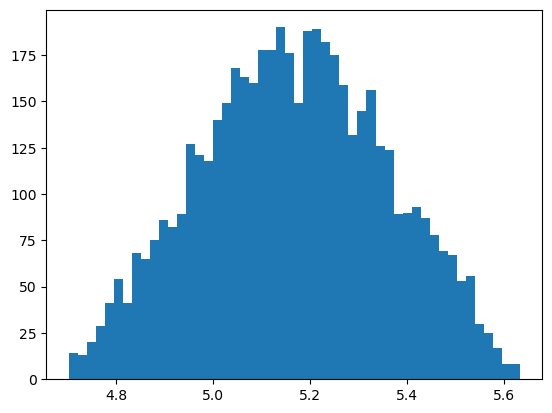

Best Possible Lineup('bettsmo01_2018', 'holtbr01_2018', 'beninan01_2018', 'martijd02_2018', 'bogaexa01_2018', 'morelmi01_2018', 'deverra01_2018', 'bradlja02_2018', 'nunezed02_2018')
With average runs: 5.632766953597189


In [78]:

from matplotlib import pyplot as plt
batters_bos = ["beninan01_2018", "bettsmo01_2018", "bogaexa01_2018", "bradlja02_2018", "deverra01_2018", "holtbr01_2018", "martijd02_2018", "morelmi01_2018", "nunezed02_2018"]

batters = ["brunter01_2008", "burrepa01_2008", "victosh01_2008", "felizpe01_2008", "howarry01_2008", "werthja01_2008", "rolliji01_2008", "ruizca01_2008", "utleych01_2008"]
best_lineup(batters_bos)

Number of lineups under consideration: 5040


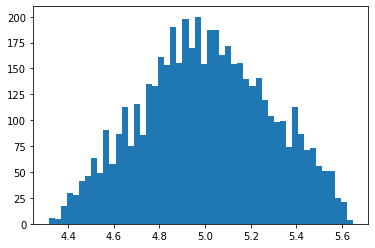

Best Possible Lineup('sotoju01_2019', 'doziebr01_2019', 'rendoan01_2019', 'adamsma01_2019', 'kendrho01_2019', 'turnetr01_2019', 'eatonad02_2019', 'gomesya01_2019', 'roblevi01_2019')
With average runs: 5.647375071857078


In [752]:
batters_wash = ["adamsma01_2019", "doziebr01_2019", "eatonad02_2019", "kendrho01_2019", "gomesya01_2019", "rendoan01_2019", "roblevi01_2019", "sotoju01_2019", "turnetr01_2019"]

batters = ["bohmal01_2021", "gregodi01_2021", "harpebr03_2021","herreod01_2021", "hoskirh01_2021","mccutan01_2021", "millebr02_2021","realmjt01_2021", "segurje01_2021"]
best_lineup(batters_wash)

In [79]:
def two_team_simulation(home_batters, home_starter, home_relievers, away_batters, away_starter, away_relievers, home_starter_innings = 6, away_starter_innings = 6):
    outcomes = np.zeros(100)
    for i in range(100):
        if i % 10 == 0:
            print("Simulating Game " + str(i) + " out of 100")
        home_score = return_mean_runs(home_batters, away_starter, away_relievers, away_starter_innings)
        away_score = return_mean_runs(away_batters, home_starter, home_relievers, home_starter_innings)
        if home_score >= away_score:
            outcomes[i] = 1
    print("Home team wins " + str(np.round(np.mean(outcomes) * 100,2)) + "% of the time.")

In [80]:
two_team_simulation(home_batters = ['burrepa01_2008', 'rolliji01_2008', 'werthja01_2008', 'howarry01_2008', 'utleych01_2008', 'victosh01_2008', 'felizpe01_2008', 'ruizca01_2008', 'brunter01_2008'], \
                   home_starter = ["nomohi01"], \
                   home_relievers = ["smithch06", "hudsoti01", "garcifr02"], \
                   away_batters = ["bohmal01_2021", "gregodi01_2021", "harpebr03_2021","herreod01_2021", "hoskirh01_2021","mccutan01_2021", "millebr02_2021","realmjt01_2021", "segurje01_2021"], \
                   away_starter = ['tiantlu01'], \
                   away_relievers = ['wolfra02', 'nomohi01', 'deleojo01'])

Simulating Game 0 out of 100
Simulating Game 10 out of 100
Simulating Game 20 out of 100
Simulating Game 30 out of 100
Simulating Game 40 out of 100
Simulating Game 50 out of 100
Simulating Game 60 out of 100
Simulating Game 70 out of 100
Simulating Game 80 out of 100
Simulating Game 90 out of 100
Home team wins 55.0% of the time.


In [82]:
mlb_teams = ['ARI', 'ATL', 'BAL', 'BOS', 'CHA', 'CHN', 'CIN', 'CLE', 'COL',

       'DET', 'FLO', 'HOU', 'KCA', 'LAA', 'LAN', 'MIL', 'MIN', 'NYA',

       'NYN', 'OAK', 'PHI', 'PIT', 'SDN', 'SEA', 'SFN', 'SLN', 'TBA',

       'TEX', 'TOR', 'WAS']

teams = mlb_teams

In [92]:
lineups_2008 = pd.DataFrame(data = {'team' : mlb_teams, 'players' : np.nan})

for i in range(len(teams)):
    team = teams[i]
    query = str("SELECT playerID FROM Batting WHERE teamID = '" + team + "' AND yearID = 2008 AND AB > 200")
    team_results = cur.execute(query).fetchall()
    flat_team = [item for sublist in team_results for item in sublist]
    flat_team = [item + "_2008" for item in flat_team]
    lineups_2008.players[i] = flat_team[0:9]

/var/folders/91/fr16yktj6gsddl5tdp89zz4r0000gn/T/ipykernel_91365/1859150779.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lineups_2008.players[i] = flat_team[0:9]


In [85]:
lineups_2008.players

0     [byrneer01_2008, drewst01_2008, hudsoor01_2008...
1     [blancgr01_2008, escobyu01_2008, francje02_200...
2     [hernara02_2008, huffau01_2008, jonesad01_2008...
3     [crispco01_2008, drewjd01_2008, ellsbja01_2008...
4     [cabreor01_2008, credejo01_2008, dyeje01_2008,...
5     [cedenro02_2008, derosma01_2008, edmonji01_200...
6     [bakopa01_2008, bruceja01_2008, dunnad01_2008,...
7     [blakeca01_2008, cabreas01_2008, carroja01_200...
8     [atkinga01_2008, bakerje03_2008, barmecl01_200...
9     [cabremi01_2008, grandcu01_2008, guillca01_200...
10    [amezaal01_2008, cantujo01_2008, gonzalu01_200...
11    [ausmubr01_2008, berkmla01_2008, blumge01_2008...
12    [avilemi01_2008, buckjo01_2008, butlebi03_2008...
13    [anderga01_2008, aybarer01_2008, figgich01_200...
14    [berroan01_2008, blakeca01_2008, dewitbl01_200...
15    [braunry02_2008, camermi01_2008, counscr01_200...
16    [buschbr01_2008, casilal01_2008, cuddymi01_200...
17    [abreubo01_2008, cabreme01_2008, canoro01_

In [99]:
bsched = pd.read_table('chicago_schedule.txt', sep=",")
bsched = bsched[['Tm', 'Opp', 'W/L']]
bsched['W/L'][bsched['W/L'] == "W-wo"] = "W"
bsched['W/L'][bsched['W/L'] == "L-wo"] = "L"
pd.factorize(bsched["W/L"])
bsched.Opp[bsched.Opp == "NYY"] = "NYA"
bsched.Opp[bsched.Opp == "TBR"] = "TBA"
bsched.Opp[bsched.Opp == "KCR"] = "KCA"
bsched.Opp[bsched.Opp == "STL"] = "SLN"
bsched.Opp[bsched.Opp == "CHW"] = "CHN"
bsched.Opp[bsched.Opp == "NYM"] = "NYN"
bsched.Opp[bsched.Opp == "SDP"] = "SDN"
bsched.Opp[bsched.Opp == "LAD"] = "LAN"
bsched.Opp[bsched.Opp == "WSN"] = "WAS"
bsched.Opp[bsched.Opp == "SFG"] = "SFN"
bsched.Opp[bsched.Opp == "FLA"] = "FLO"
bsched.Opp[bsched.Opp == "NYY"] = "NYA"
bsched.Tm[bsched.Tm == "CHC"] = "CHN"
bsched

,Tm,Opp,W/L
0,CHN,MIL,L
1,CHN,MIL,L
2,CHN,MIL,W
3,CHN,HOU,L
4,CHN,HOU,W
...,...,...,...
156,CHN,NYN,W
157,CHN,NYN,L
158,CHN,MIL,L
159,CHN,MIL,W


In [94]:
from sklearn.metrics import confusion_matrix

def simulate_season(schedule, lineups):
    outcomes = np.empty(schedule.shape[0], dtype='object')
    for i in range(schedule.shape[0]):        
        team = schedule.Tm[i]
        opp = schedule.Opp[i]
        
        team_lineup = lineups.players[lineups.team == team]
        team_lineup = team_lineup.to_list()[0]
        
        # print(opp)
        opp_lineup = lineups.players[lineups.team == opp]
        opp_lineup = opp_lineup.to_list()[0]
        
        while outcomes[i] == None:
            
            markov_simulation = MarkovSimulation(termination_threshold=1e-4)
            lineup = initialize_lineup()
            for j in range(9):
                # print(i)
                batter = team_lineup[j]
                batter_object = player_registry.registry[batter]
                lineup = update_lineup(lineup, j, batter_object)

            team_outcome = random.sample(markov_simulation(
                lineup=lineup, running_event_probabilities=running_event_probs)[-10]._states, 1)[0].game_state.score
            
            markov_simulation = MarkovSimulation(termination_threshold=1e-4)
            lineup = initialize_lineup()
            for j in range(9):
                # print(i)
                batter = opp_lineup[j]
                batter_object = player_registry.registry[batter]
                lineup = update_lineup(lineup, j, batter_object)

            opp_outcome = random.sample(markov_simulation(
                lineup=lineup, running_event_probabilities=running_event_probs)[-10]._states, 1)[0].game_state.score
            #print(team_outcome)
            if (team_outcome > opp_outcome):
                outcomes[i] = "W"
            elif (team_outcome < opp_outcome):
                outcomes[i] = "L"
        if i % 10 == 0:
            print("Sample simulated outcome: " + str(team) + ": " + str(team_outcome) + " vs. " + str(opp) + ": " + str(opp_outcome))
    print(outcomes)
    print(confusion_matrix(y_true = schedule["W/L"], y_pred = outcomes))

In [108]:
chi_sched = pd.read_table('chicago_schedule.txt', sep=",")
chi_sched = chi_sched[['Tm', 'Opp', 'W/L']]
chi_sched['W/L'][chi_sched['W/L'] == "W-wo"] = "W"
chi_sched['W/L'][chi_sched['W/L'] == "L-wo"] = "L"
pd.factorize(chi_sched["W/L"])
chi_sched.Opp[chi_sched.Opp == "NYY"] = "NYA"
chi_sched.Opp[chi_sched.Opp == "TBR"] = "TBA"
chi_sched.Opp[chi_sched.Opp == "KCR"] = "KCA"
chi_sched.Opp[chi_sched.Opp == "STL"] = "SLN"
chi_sched.Opp[chi_sched.Opp == "CHW"] = "CHA"
chi_sched.Opp[chi_sched.Opp == "NYM"] = "NYN"
chi_sched.Opp[chi_sched.Opp == "SDP"] = "SDN"
chi_sched.Opp[chi_sched.Opp == "LAD"] = "LAN"
chi_sched.Opp[chi_sched.Opp == "WSN"] = "WAS"
chi_sched.Opp[chi_sched.Opp == "SFG"] = "SFN"
chi_sched.Opp[chi_sched.Opp == "FLA"] = "FLO"
chi_sched.Opp[chi_sched.Opp == "CHC"] = "CHN"
chi_sched.Tm[chi_sched.Tm == "CHC"] = "CHN"

chi_sched

,Tm,Opp,W/L
0,CHN,MIL,L
1,CHN,MIL,L
2,CHN,MIL,W
3,CHN,HOU,L
4,CHN,HOU,W
...,...,...,...
156,CHN,NYN,W
157,CHN,NYN,L
158,CHN,MIL,L
159,CHN,MIL,W


In [109]:
simulate_season(chi_sched, lineups_2008)

Sample simulated outcome: CHN: 4 vs. MIL: 3
Sample simulated outcome: CHN: 3 vs. PHI: 2
Sample simulated outcome: CHN: 3 vs. COL: 2
Sample simulated outcome: CHN: 5 vs. SLN: 2
Sample simulated outcome: CHN: 1 vs. SDN: 3
Sample simulated outcome: CHN: 1 vs. LAN: 0
Sample simulated outcome: CHN: 3 vs. LAN: 2
Sample simulated outcome: CHN: 5 vs. TBA: 2
Sample simulated outcome: CHN: 3 vs. CHA: 5
Sample simulated outcome: CHN: 4 vs. CIN: 3
Sample simulated outcome: CHN: 2 vs. ARI: 3
Sample simulated outcome: CHN: 3 vs. PIT: 0
Sample simulated outcome: CHN: 6 vs. ATL: 3
Sample simulated outcome: CHN: 4 vs. PIT: 1
Sample simulated outcome: CHN: 3 vs. CIN: 4
Sample simulated outcome: CHN: 3 vs. MIL: 4
Sample simulated outcome: CHN: 3 vs. MIL: 0
['W' 'L' 'L' 'L' 'W' 'L' 'W' 'W' 'L' 'W' 'W' 'L' 'W' 'W' 'W' 'W' 'W' 'L'
 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'L' 'W' 'L' 'W' 'W' 'L' 'W' 'L' 'W'
 'W' 'L' 'W' 'L' 'L' 'W' 'L' 'W' 'W' 'L' 'W' 'W' 'W' 'L' 'W' 'L' 'L' 'W'
 'L' 'L' 'W' 'L' 'W' 'L' 'W' 'W' 

In [110]:
cin_sched = pd.read_table('cin_schedule.txt', sep=",")
cin_sched = cin_sched[['Tm', 'Opp', 'W/L']]
cin_sched['W/L'][cin_sched['W/L'] == "W-wo"] = "W"
cin_sched['W/L'][cin_sched['W/L'] == "L-wo"] = "L"
pd.factorize(cin_sched["W/L"])
cin_sched.Opp[cin_sched.Opp == "NYY"] = "NYA"
cin_sched.Opp[cin_sched.Opp == "TBR"] = "TBA"
cin_sched.Opp[cin_sched.Opp == "KCR"] = "KCA"
cin_sched.Opp[cin_sched.Opp == "STL"] = "SLN"
cin_sched.Opp[cin_sched.Opp == "CHW"] = "CHA"
cin_sched.Opp[cin_sched.Opp == "NYM"] = "NYN"
cin_sched.Opp[cin_sched.Opp == "SDP"] = "SDN"
cin_sched.Opp[cin_sched.Opp == "LAD"] = "LAN"
cin_sched.Opp[cin_sched.Opp == "WSN"] = "WAS"
cin_sched.Opp[cin_sched.Opp == "SFG"] = "SFN"
cin_sched.Opp[cin_sched.Opp == "FLA"] = "FLO"
cin_sched.Opp[cin_sched.Opp == "CHC"] = "CHN"

cin_sched

,Tm,Opp,W/L
0,CIN,ARI,L
1,CIN,ARI,W
2,CIN,ARI,W
3,CIN,PHI,L
4,CIN,PHI,W
...,...,...,...
157,CIN,HOU,L
158,CIN,HOU,L
159,CIN,SLN,L
160,CIN,SLN,L


In [111]:
simulate_season(cin_sched, lineups_2008)

Sample simulated outcome: CIN: 4 vs. ARI: 3
Sample simulated outcome: CIN: 1 vs. PIT: 3
Sample simulated outcome: CIN: 3 vs. LAN: 0
Sample simulated outcome: CIN: 2 vs. ATL: 5
Sample simulated outcome: CIN: 0 vs. FLO: 2
Sample simulated outcome: CIN: 0 vs. SDN: 2
Sample simulated outcome: CIN: 2 vs. PHI: 5
Sample simulated outcome: CIN: 3 vs. BOS: 4
Sample simulated outcome: CIN: 3 vs. CLE: 2
Sample simulated outcome: CIN: 3 vs. CHN: 2
Sample simulated outcome: CIN: 2 vs. SDN: 1
Sample simulated outcome: CIN: 2 vs. WAS: 0
Sample simulated outcome: CIN: 0 vs. PIT: 3
Sample simulated outcome: CIN: 2 vs. COL: 1
Sample simulated outcome: CIN: 3 vs. CHN: 0
Sample simulated outcome: CIN: 0 vs. SLN: 3
Sample simulated outcome: CIN: 2 vs. SLN: 5
['W' 'L' 'W' 'L' 'L' 'L' 'W' 'W' 'L' 'W' 'L' 'L' 'L' 'L' 'L' 'W' 'W' 'W'
 'L' 'W' 'W' 'W' 'W' 'L' 'L' 'L' 'W' 'W' 'L' 'L' 'L' 'W' 'L' 'W' 'L' 'W'
 'L' 'W' 'L' 'L' 'L' 'W' 'W' 'W' 'W' 'L' 'L' 'W' 'W' 'L' 'L' 'W' 'L' 'L'
 'L' 'L' 'W' 'L' 'L' 'W' 'L' 'W' 

In [128]:
mil_sched = pd.read_table('mil_schedule.txt', sep=",")
mil_sched = mil_sched[['Tm', 'Opp', 'W/L']]
mil_sched['W/L'][mil_sched['W/L'] == "W-wo"] = "W"
mil_sched['W/L'][mil_sched['W/L'] == "L-wo"] = "L"
mil_sched['W/L'][mil_sched['W/L'] == "W &V"] = "W"
pd.factorize(mil_sched["W/L"])
mil_sched.Opp[mil_sched.Opp == "NYY"] = "NYA"
mil_sched.Opp[mil_sched.Opp == "TBR"] = "TBA"
mil_sched.Opp[mil_sched.Opp == "KCR"] = "KCA"
mil_sched.Opp[mil_sched.Opp == "STL"] = "SLN"
mil_sched.Opp[mil_sched.Opp == "CHW"] = "CHA"
mil_sched.Opp[mil_sched.Opp == "NYM"] = "NYN"
mil_sched.Opp[mil_sched.Opp == "SDP"] = "SDN"
mil_sched.Opp[mil_sched.Opp == "LAD"] = "LAN"
mil_sched.Opp[mil_sched.Opp == "WSN"] = "WAS"
mil_sched.Opp[mil_sched.Opp == "SFG"] = "SFN"
mil_sched.Opp[mil_sched.Opp == "FLA"] = "FLO"
mil_sched.Opp[mil_sched.Opp == "CHC"] = "CHN"

mil_sched

,Tm,Opp,W/L
0,MIL,CHN,W
1,MIL,CHN,W
2,MIL,CHN,L
3,MIL,SFN,W
4,MIL,SFN,W
...,...,...,...
157,MIL,PIT,W
158,MIL,PIT,W
159,MIL,CHN,W
160,MIL,CHN,L


In [129]:
simulate_season(mil_sched, lineups_2008)

Sample simulated outcome: MIL: 5 vs. CHN: 3
Sample simulated outcome: MIL: 1 vs. NYN: 4
Sample simulated outcome: MIL: 4 vs. PHI: 1
Sample simulated outcome: MIL: 4 vs. HOU: 1
Sample simulated outcome: MIL: 1 vs. LAN: 0
Sample simulated outcome: MIL: 2 vs. WAS: 3
Sample simulated outcome: MIL: 2 vs. COL: 1
Sample simulated outcome: MIL: 3 vs. TOR: 2
Sample simulated outcome: MIL: 0 vs. MIN: 1
Sample simulated outcome: MIL: 4 vs. COL: 3
Sample simulated outcome: MIL: 2 vs. SLN: 6
Sample simulated outcome: MIL: 1 vs. ATL: 2
Sample simulated outcome: MIL: 4 vs. SDN: 3
Sample simulated outcome: MIL: 1 vs. PIT: 2
Sample simulated outcome: MIL: 2 vs. SDN: 3
Sample simulated outcome: MIL: 3 vs. CHN: 4
Sample simulated outcome: MIL: 1 vs. CHN: 0
['W' 'L' 'L' 'L' 'L' 'L' 'L' 'W' 'W' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'W'
 'L' 'L' 'W' 'W' 'L' 'L' 'W' 'L' 'W' 'L' 'W' 'W' 'W' 'L' 'W' 'L' 'L' 'W'
 'W' 'L' 'L' 'W' 'W' 'W' 'W' 'L' 'W' 'L' 'L' 'L' 'W' 'L' 'L' 'W' 'W' 'L'
 'L' 'W' 'L' 'W' 'L' 'L' 'W' 'L' 

In [123]:
pit_sched = pd.read_table('pit_schedule.txt', sep=",")
pit_sched = pit_sched[['Tm', 'Opp', 'W/L']]
pit_sched['W/L'][pit_sched['W/L'] == "W-wo"] = "W"
pit_sched['W/L'][pit_sched['W/L'] == "L-wo"] = "L"
pit_sched['W/L'][pit_sched['W/L'] == "L &V"] = "L"
pd.factorize(pit_sched["W/L"])
pit_sched.Opp[pit_sched.Opp == "NYY"] = "NYA"
pit_sched.Opp[pit_sched.Opp == "TBR"] = "TBA"
pit_sched.Opp[pit_sched.Opp == "KCR"] = "KCA"
pit_sched.Opp[pit_sched.Opp == "STL"] = "SLN"
pit_sched.Opp[pit_sched.Opp == "CHW"] = "CHA"
pit_sched.Opp[pit_sched.Opp == "NYM"] = "NYN"
pit_sched.Opp[pit_sched.Opp == "SDP"] = "SDN"
pit_sched.Opp[pit_sched.Opp == "LAD"] = "LAN"
pit_sched.Opp[pit_sched.Opp == "WSN"] = "WAS"
pit_sched.Opp[pit_sched.Opp == "SFG"] = "SFN"
pit_sched.Opp[pit_sched.Opp == "FLA"] = "FLO"
pit_sched.Opp[pit_sched.Opp == "CHC"] = "CHN"

pit_sched

,Tm,Opp,W/L
0,PIT,ATL,W
1,PIT,ATL,L
2,PIT,ATL,W
3,PIT,FLO,L
4,PIT,FLO,L
...,...,...,...
157,PIT,MIL,L
158,PIT,MIL,L
159,PIT,SDN,W
160,PIT,SDN,L


In [124]:
simulate_season(pit_sched, lineups_2008)

Sample simulated outcome: PIT: 0 vs. ATL: 3
Sample simulated outcome: PIT: 2 vs. CIN: 3
Sample simulated outcome: PIT: 2 vs. SLN: 0
Sample simulated outcome: PIT: 5 vs. WAS: 3
Sample simulated outcome: PIT: 1 vs. SLN: 2
Sample simulated outcome: PIT: 2 vs. CIN: 1
Sample simulated outcome: PIT: 4 vs. ARI: 2
Sample simulated outcome: PIT: 0 vs. CHA: 3
Sample simulated outcome: PIT: 1 vs. TBA: 0
Sample simulated outcome: PIT: 1 vs. NYA: 0
Sample simulated outcome: PIT: 1 vs. HOU: 3
Sample simulated outcome: PIT: 3 vs. CHN: 1
Sample simulated outcome: PIT: 2 vs. CIN: 1
Sample simulated outcome: PIT: 2 vs. CHN: 3
Sample simulated outcome: PIT: 3 vs. SFN: 5
Sample simulated outcome: PIT: 3 vs. LAN: 1
Sample simulated outcome: PIT: 1 vs. SDN: 0
['L' 'W' 'W' 'W' 'L' 'L' 'L' 'L' 'W' 'L' 'L' 'L' 'W' 'W' 'W' 'W' 'W' 'W'
 'L' 'W' 'W' 'W' 'L' 'W' 'W' 'L' 'W' 'L' 'L' 'W' 'W' 'L' 'L' 'W' 'W' 'L'
 'L' 'W' 'W' 'L' 'L' 'L' 'L' 'W' 'L' 'W' 'W' 'L' 'L' 'L' 'W' 'L' 'W' 'L'
 'L' 'W' 'W' 'W' 'L' 'W' 'W' 'L' 

In [134]:
stl_sched = pd.read_table('stl_schedule.txt', sep=",")
stl_sched = stl_sched[['Tm', 'Opp', 'W/L']]
stl_sched['W/L'][stl_sched['W/L'] == "W-wo"] = "W"
stl_sched['W/L'][stl_sched['W/L'] == "L-wo"] = "L"
stl_sched['W/L'][stl_sched['W/L'] == "L &V"] = "L"
pd.factorize(stl_sched["W/L"])
stl_sched.Opp[stl_sched.Opp == "NYY"] = "NYA"
stl_sched.Opp[stl_sched.Opp == "TBR"] = "TBA"
stl_sched.Opp[stl_sched.Opp == "KCR"] = "KCA"
stl_sched.Opp[stl_sched.Opp == "STL"] = "SLN"
stl_sched.Opp[stl_sched.Opp == "CHW"] = "CHA"
stl_sched.Opp[stl_sched.Opp == "NYM"] = "NYN"
stl_sched.Opp[stl_sched.Opp == "SDP"] = "SDN"
stl_sched.Opp[stl_sched.Opp == "LAD"] = "LAN"
stl_sched.Opp[stl_sched.Opp == "WSN"] = "WAS"
stl_sched.Opp[stl_sched.Opp == "SFG"] = "SFN"
stl_sched.Opp[stl_sched.Opp == "FLA"] = "FLO"
stl_sched.Opp[stl_sched.Opp == "CHC"] = "CHN"
stl_sched.Tm[stl_sched.Tm == "STL"] = "SLN"

stl_sched

,Tm,Opp,W/L
0,SLN,COL,L
1,SLN,COL,W
2,SLN,COL,W
3,SLN,WAS,W
4,SLN,WAS,W
...,...,...,...
157,SLN,ARI,W
158,SLN,ARI,W
159,SLN,CIN,W
160,SLN,CIN,W


In [135]:
simulate_season(stl_sched, lineups_2008)

Sample simulated outcome: SLN: 3 vs. COL: 2
Sample simulated outcome: SLN: 3 vs. SFN: 0
Sample simulated outcome: SLN: 6 vs. MIL: 2
Sample simulated outcome: SLN: 2 vs. CHN: 0
Sample simulated outcome: SLN: 3 vs. PIT: 1
Sample simulated outcome: SLN: 0 vs. LAN: 1
Sample simulated outcome: SLN: 2 vs. WAS: 0
Sample simulated outcome: SLN: 5 vs. PHI: 2
Sample simulated outcome: SLN: 2 vs. KCA: 3
Sample simulated outcome: SLN: 3 vs. PHI: 0
Sample simulated outcome: SLN: 2 vs. MIL: 1
Sample simulated outcome: SLN: 4 vs. ATL: 5
Sample simulated outcome: SLN: 6 vs. FLO: 2
Sample simulated outcome: SLN: 4 vs. ATL: 2
Sample simulated outcome: SLN: 4 vs. FLO: 2
Sample simulated outcome: SLN: 4 vs. CIN: 3
Sample simulated outcome: SLN: 6 vs. CIN: 0
['W' 'L' 'L' 'W' 'L' 'W' 'W' 'W' 'L' 'W' 'W' 'W' 'W' 'L' 'L' 'L' 'L' 'W'
 'W' 'W' 'W' 'W' 'W' 'L' 'W' 'W' 'L' 'L' 'L' 'L' 'W' 'L' 'W' 'L' 'W' 'W'
 'L' 'L' 'W' 'W' 'W' 'L' 'W' 'W' 'W' 'W' 'L' 'L' 'L' 'W' 'L' 'L' 'W' 'W'
 'W' 'W' 'L' 'W' 'W' 'W' 'W' 'W' 

In [137]:
atl_sched = pd.read_table('atl_schedule.txt', sep=",")
atl_sched = atl_sched[['Tm', 'Opp', 'W/L']]
atl_sched['W/L'][atl_sched['W/L'] == "W-wo"] = "W"
atl_sched['W/L'][atl_sched['W/L'] == "L-wo"] = "L"
atl_sched['W/L'][atl_sched['W/L'] == "L &V"] = "L"
pd.factorize(atl_sched["W/L"])
atl_sched.Opp[atl_sched.Opp == "NYY"] = "NYA"
atl_sched.Opp[atl_sched.Opp == "TBR"] = "TBA"
atl_sched.Opp[atl_sched.Opp == "KCR"] = "KCA"
atl_sched.Opp[atl_sched.Opp == "STL"] = "SLN"
atl_sched.Opp[atl_sched.Opp == "CHW"] = "CHA"
atl_sched.Opp[atl_sched.Opp == "NYM"] = "NYN"
atl_sched.Opp[atl_sched.Opp == "SDP"] = "SDN"
atl_sched.Opp[atl_sched.Opp == "LAD"] = "LAN"
atl_sched.Opp[atl_sched.Opp == "WSN"] = "WAS"
atl_sched.Opp[atl_sched.Opp == "SFG"] = "SFN"
atl_sched.Opp[atl_sched.Opp == "FLA"] = "FLO"
atl_sched.Opp[atl_sched.Opp == "CHC"] = "CHN"


atl_sched

,Tm,Opp,W/L
0,ATL,WAS,L
1,ATL,PIT,L
2,ATL,PIT,W
3,ATL,PIT,L
4,ATL,NYN,W
...,...,...,...
157,ATL,PHI,W
158,ATL,PHI,W
159,ATL,HOU,L
160,ATL,HOU,W


In [138]:
simulate_season(atl_sched, lineups_2008)

Sample simulated outcome: ATL: 5 vs. WAS: 4
Sample simulated outcome: ATL: 1 vs. WAS: 3
Sample simulated outcome: ATL: 3 vs. FLO: 1
Sample simulated outcome: ATL: 1 vs. SDN: 4
Sample simulated outcome: ATL: 0 vs. OAK: 1
Sample simulated outcome: ATL: 6 vs. ARI: 1
Sample simulated outcome: ATL: 1 vs. FLO: 2
Sample simulated outcome: ATL: 6 vs. COL: 0
Sample simulated outcome: ATL: 3 vs. TOR: 1
Sample simulated outcome: ATL: 5 vs. LAN: 2
Sample simulated outcome: ATL: 0 vs. FLO: 2
Sample simulated outcome: ATL: 0 vs. MIL: 3
Sample simulated outcome: ATL: 1 vs. CHN: 4
Sample simulated outcome: ATL: 3 vs. SLN: 5
Sample simulated outcome: ATL: 2 vs. WAS: 1
Sample simulated outcome: ATL: 0 vs. PHI: 1
Sample simulated outcome: ATL: 3 vs. HOU: 1
['W' 'W' 'W' 'L' 'L' 'W' 'W' 'W' 'L' 'W' 'L' 'W' 'W' 'W' 'W' 'L' 'W' 'L'
 'L' 'W' 'W' 'L' 'L' 'W' 'W' 'W' 'L' 'L' 'W' 'W' 'L' 'W' 'W' 'L' 'W' 'W'
 'W' 'L' 'W' 'L' 'L' 'L' 'L' 'W' 'W' 'W' 'W' 'L' 'W' 'W' 'W' 'W' 'L' 'L'
 'W' 'W' 'W' 'W' 'W' 'W' 'L' 'W' 

In [141]:
fla_sched = pd.read_table('fla_schedule.txt', sep=",")
fla_sched = fla_sched[['Tm', 'Opp', 'W/L']]
fla_sched['W/L'][fla_sched['W/L'] == "W-wo"] = "W"
fla_sched['W/L'][fla_sched['W/L'] == "L-wo"] = "L"
fla_sched['W/L'][fla_sched['W/L'] == "L &V"] = "L"
pd.factorize(fla_sched["W/L"])
fla_sched.Opp[fla_sched.Opp == "NYY"] = "NYA"
fla_sched.Opp[fla_sched.Opp == "TBR"] = "TBA"
fla_sched.Opp[fla_sched.Opp == "KCR"] = "KCA"
fla_sched.Opp[fla_sched.Opp == "STL"] = "SLN"
fla_sched.Opp[fla_sched.Opp == "CHW"] = "CHA"
fla_sched.Opp[fla_sched.Opp == "NYM"] = "NYN"
fla_sched.Opp[fla_sched.Opp == "SDP"] = "SDN"
fla_sched.Opp[fla_sched.Opp == "LAD"] = "LAN"
fla_sched.Opp[fla_sched.Opp == "WSN"] = "WAS"
fla_sched.Opp[fla_sched.Opp == "SFG"] = "SFN"
fla_sched.Opp[fla_sched.Opp == "FLA"] = "FLO"
fla_sched.Opp[fla_sched.Opp == "CHC"] = "CHN"
fla_sched.Tm[fla_sched.Tm == "FLA"] = "FLO"

fla_sched

,Tm,Opp,W/L
0,FLO,NYN,L
1,FLO,NYN,W
2,FLO,NYN,L
3,FLO,PIT,W
4,FLO,PIT,W
...,...,...,...
156,FLO,WAS,L
157,FLO,WAS,W
158,FLO,NYN,W
159,FLO,NYN,L


In [142]:
simulate_season(fla_sched, lineups_2008)

Sample simulated outcome: FLO: 3 vs. NYN: 1
Sample simulated outcome: FLO: 2 vs. HOU: 3
Sample simulated outcome: FLO: 0 vs. ATL: 3
Sample simulated outcome: FLO: 4 vs. SDN: 0
Sample simulated outcome: FLO: 3 vs. KCA: 4
Sample simulated outcome: FLO: 4 vs. NYN: 5
Sample simulated outcome: FLO: 2 vs. CIN: 1
Sample simulated outcome: FLO: 2 vs. SEA: 4
Sample simulated outcome: FLO: 3 vs. ARI: 0
Sample simulated outcome: FLO: 5 vs. SDN: 2
Sample simulated outcome: FLO: 3 vs. ATL: 5
Sample simulated outcome: FLO: 5 vs. COL: 2
Sample simulated outcome: FLO: 2 vs. SLN: 4
Sample simulated outcome: FLO: 2 vs. ARI: 5
Sample simulated outcome: FLO: 2 vs. SLN: 4
Sample simulated outcome: FLO: 2 vs. HOU: 0
Sample simulated outcome: FLO: 1 vs. NYN: 4
['W' 'W' 'L' 'W' 'W' 'L' 'L' 'L' 'L' 'W' 'L' 'W' 'L' 'W' 'L' 'L' 'W' 'W'
 'L' 'L' 'L' 'L' 'W' 'W' 'W' 'L' 'L' 'W' 'L' 'L' 'W' 'W' 'L' 'L' 'W' 'W'
 'W' 'W' 'W' 'W' 'L' 'L' 'W' 'W' 'W' 'W' 'L' 'L' 'W' 'L' 'L' 'L' 'W' 'W'
 'L' 'L' 'L' 'L' 'W' 'W' 'W' 'L' 

In [144]:
nym_sched = pd.read_table('nym_schedule.txt', sep=",")
nym_sched = nym_sched[['Tm', 'Opp', 'W/L']]
nym_sched['W/L'][nym_sched['W/L'] == "W-wo"] = "W"
nym_sched['W/L'][nym_sched['W/L'] == "L-wo"] = "L"
nym_sched['W/L'][nym_sched['W/L'] == "L &V"] = "L"
pd.factorize(nym_sched["W/L"])
nym_sched.Opp[nym_sched.Opp == "NYY"] = "NYA"
nym_sched.Opp[nym_sched.Opp == "TBR"] = "TBA"
nym_sched.Opp[nym_sched.Opp == "KCR"] = "KCA"
nym_sched.Opp[nym_sched.Opp == "STL"] = "SLN"
nym_sched.Opp[nym_sched.Opp == "CHW"] = "CHA"
nym_sched.Opp[nym_sched.Opp == "NYM"] = "NYN"
nym_sched.Opp[nym_sched.Opp == "SDP"] = "SDN"
nym_sched.Opp[nym_sched.Opp == "LAD"] = "LAN"
nym_sched.Opp[nym_sched.Opp == "WSN"] = "WAS"
nym_sched.Opp[nym_sched.Opp == "SFG"] = "SFN"
nym_sched.Opp[nym_sched.Opp == "FLA"] = "FLO"
nym_sched.Opp[nym_sched.Opp == "CHC"] = "CHN"
nym_sched.Tm[nym_sched.Tm == "NYM"] = "NYN"

nym_sched

,Tm,Opp,W/L
0,NYN,FLO,W
1,NYN,FLO,L
2,NYN,FLO,W
3,NYN,ATL,L
4,NYN,ATL,L
...,...,...,...
157,NYN,CHN,L
158,NYN,CHN,W
159,NYN,FLO,L
160,NYN,FLO,W


In [145]:
simulate_season(nym_sched, lineups_2008)

Sample simulated outcome: NYN: 1 vs. FLO: 2
Sample simulated outcome: NYN: 0 vs. MIL: 2
Sample simulated outcome: NYN: 4 vs. WAS: 2
Sample simulated outcome: NYN: 3 vs. LAN: 2
Sample simulated outcome: NYN: 4 vs. NYA: 3
Sample simulated outcome: NYN: 1 vs. FLO: 2
Sample simulated outcome: NYN: 3 vs. SDN: 2
Sample simulated outcome: NYN: 2 vs. LAA: 3
Sample simulated outcome: NYN: 4 vs. NYA: 2
Sample simulated outcome: NYN: 1 vs. SFN: 3
Sample simulated outcome: NYN: 4 vs. PHI: 2
Sample simulated outcome: NYN: 0 vs. HOU: 1
Sample simulated outcome: NYN: 0 vs. WAS: 3
Sample simulated outcome: NYN: 2 vs. HOU: 4
Sample simulated outcome: NYN: 1 vs. PHI: 4
Sample simulated outcome: NYN: 2 vs. WAS: 3
Sample simulated outcome: NYN: 3 vs. FLO: 1
['L' 'L' 'W' 'L' 'L' 'L' 'W' 'W' 'L' 'L' 'L' 'L' 'W' 'W' 'L' 'L' 'W' 'L'
 'L' 'W' 'W' 'W' 'L' 'W' 'L' 'W' 'W' 'L' 'L' 'L' 'W' 'L' 'L' 'L' 'L' 'W'
 'W' 'W' 'L' 'W' 'W' 'W' 'L' 'L' 'L' 'W' 'W' 'W' 'L' 'W' 'L' 'L' 'W' 'L'
 'L' 'W' 'L' 'L' 'L' 'L' 'W' 'L' 

In [147]:
phi_sched = pd.read_table('phi_schedule.txt', sep=",")
phi_sched = phi_sched[['Tm', 'Opp', 'W/L']]
phi_sched['W/L'][phi_sched['W/L'] == "W-wo"] = "W"
phi_sched['W/L'][phi_sched['W/L'] == "L-wo"] = "L"
phi_sched['W/L'][phi_sched['W/L'] == "L &V"] = "L"
pd.factorize(phi_sched["W/L"])
phi_sched.Opp[phi_sched.Opp == "NYY"] = "NYA"
phi_sched.Opp[phi_sched.Opp == "TBR"] = "TBA"
phi_sched.Opp[phi_sched.Opp == "KCR"] = "KCA"
phi_sched.Opp[phi_sched.Opp == "STL"] = "SLN"
phi_sched.Opp[phi_sched.Opp == "CHW"] = "CHA"
phi_sched.Opp[phi_sched.Opp == "NYM"] = "NYN"
phi_sched.Opp[phi_sched.Opp == "SDP"] = "SDN"
phi_sched.Opp[phi_sched.Opp == "LAD"] = "LAN"
phi_sched.Opp[phi_sched.Opp == "WSN"] = "WAS"
phi_sched.Opp[phi_sched.Opp == "SFG"] = "SFN"
phi_sched.Opp[phi_sched.Opp == "FLA"] = "FLO"
phi_sched.Opp[phi_sched.Opp == "CHC"] = "CHN"
phi_sched.Tm[phi_sched.Tm == "NYM"] = "NYN"

phi_sched

,Tm,Opp,W/L
0,PHI,WAS,L
1,PHI,WAS,L
2,PHI,WAS,W
3,PHI,CIN,W
4,PHI,CIN,L
...,...,...,...
157,PHI,ATL,L
158,PHI,ATL,L
159,PHI,WAS,W
160,PHI,WAS,W


In [148]:
simulate_season(phi_sched, lineups_2008)

Sample simulated outcome: PHI: 3 vs. WAS: 2
Sample simulated outcome: PHI: 3 vs. CHN: 2
Sample simulated outcome: PHI: 1 vs. COL: 0
Sample simulated outcome: PHI: 3 vs. SFN: 5
Sample simulated outcome: PHI: 1 vs. ATL: 4
Sample simulated outcome: PHI: 0 vs. HOU: 3
Sample simulated outcome: PHI: 3 vs. CIN: 4
Sample simulated outcome: PHI: 0 vs. SLN: 3
Sample simulated outcome: PHI: 2 vs. TEX: 5
Sample simulated outcome: PHI: 2 vs. SLN: 0
Sample simulated outcome: PHI: 2 vs. NYN: 3
Sample simulated outcome: PHI: 3 vs. SLN: 5
Sample simulated outcome: PHI: 1 vs. LAN: 3
Sample simulated outcome: PHI: 0 vs. LAN: 3
Sample simulated outcome: PHI: 4 vs. NYN: 2
Sample simulated outcome: PHI: 0 vs. ATL: 1
Sample simulated outcome: PHI: 1 vs. WAS: 3
['W' 'L' 'L' 'W' 'W' 'L' 'L' 'L' 'L' 'L' 'W' 'L' 'W' 'W' 'L' 'L' 'L' 'L'
 'W' 'L' 'W' 'L' 'W' 'L' 'L' 'W' 'W' 'W' 'W' 'W' 'L' 'L' 'W' 'L' 'L' 'W'
 'L' 'W' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'W' 'W' 'L' 'L' 'W' 'W'
 'W' 'L' 'W' 'W' 'L' 'L' 'L' 'W' 

In [152]:
was_sched = pd.read_table('was_schedule.txt', sep=",")
was_sched = was_sched[['Tm', 'Opp', 'W/L']]
was_sched['W/L'][was_sched['W/L'] == "W-wo"] = "W"
was_sched['W/L'][was_sched['W/L'] == "L-wo"] = "L"
was_sched['W/L'][was_sched['W/L'] == "L &V"] = "L"
pd.factorize(was_sched["W/L"])
was_sched.Opp[was_sched.Opp == "NYY"] = "NYA"
was_sched.Opp[was_sched.Opp == "TBR"] = "TBA"
was_sched.Opp[was_sched.Opp == "KCR"] = "KCA"
was_sched.Opp[was_sched.Opp == "STL"] = "SLN"
was_sched.Opp[was_sched.Opp == "CHW"] = "CHA"
was_sched.Opp[was_sched.Opp == "NYM"] = "NYN"
was_sched.Opp[was_sched.Opp == "SDP"] = "SDN"
was_sched.Opp[was_sched.Opp == "LAD"] = "LAN"
was_sched.Opp[was_sched.Opp == "WSN"] = "WAS"
was_sched.Opp[was_sched.Opp == "SFG"] = "SFN"
was_sched.Opp[was_sched.Opp == "FLA"] = "FLO"
was_sched.Opp[was_sched.Opp == "CHC"] = "CHN"
was_sched.Tm[was_sched.Tm == "WSN"] = "WAS"

was_sched

,Tm,Opp,W/L
0,WAS,ATL,W
1,WAS,PHI,W
2,WAS,PHI,W
3,WAS,PHI,L
4,WAS,SLN,L
...,...,...,...
156,WAS,FLO,W
157,WAS,FLO,L
158,WAS,PHI,L
159,WAS,PHI,L


In [153]:
simulate_season(was_sched, lineups_2008)

Sample simulated outcome: WAS: 2 vs. ATL: 5
Sample simulated outcome: WAS: 1 vs. ATL: 5
Sample simulated outcome: WAS: 1 vs. ATL: 2
Sample simulated outcome: WAS: 2 vs. PIT: 4
Sample simulated outcome: WAS: 0 vs. NYN: 3
Sample simulated outcome: WAS: 4 vs. MIL: 1
Sample simulated outcome: WAS: 3 vs. SLN: 2
Sample simulated outcome: WAS: 2 vs. SEA: 1
Sample simulated outcome: WAS: 3 vs. BAL: 4
Sample simulated outcome: WAS: 3 vs. ARI: 1
Sample simulated outcome: WAS: 3 vs. SFN: 4
Sample simulated outcome: WAS: 2 vs. CIN: 3
Sample simulated outcome: WAS: 2 vs. NYN: 5
Sample simulated outcome: WAS: 3 vs. CHN: 4
Sample simulated outcome: WAS: 3 vs. ATL: 2
Sample simulated outcome: WAS: 2 vs. NYN: 0
Sample simulated outcome: WAS: 2 vs. PHI: 3
['L' 'L' 'W' 'W' 'L' 'L' 'L' 'W' 'L' 'W' 'L' 'W' 'L' 'L' 'W' 'W' 'L' 'L'
 'W' 'L' 'L' 'L' 'L' 'W' 'W' 'L' 'L' 'L' 'W' 'L' 'L' 'L' 'W' 'L' 'W' 'W'
 'W' 'W' 'L' 'W' 'L' 'W' 'W' 'W' 'L' 'L' 'L' 'L' 'L' 'W' 'W' 'W' 'W' 'L'
 'W' 'L' 'L' 'L' 'W' 'L' 'W' 'L' 

In [155]:
ari_sched = pd.read_table('ari_schedule.txt', sep=",")
ari_sched = ari_sched[['Tm', 'Opp', 'W/L']]
ari_sched['W/L'][ari_sched['W/L'] == "W-wo"] = "W"
ari_sched['W/L'][ari_sched['W/L'] == "L-wo"] = "L"
ari_sched['W/L'][ari_sched['W/L'] == "L &V"] = "L"
pd.factorize(ari_sched["W/L"])
ari_sched.Opp[ari_sched.Opp == "NYY"] = "NYA"
ari_sched.Opp[ari_sched.Opp == "TBR"] = "TBA"
ari_sched.Opp[ari_sched.Opp == "KCR"] = "KCA"
ari_sched.Opp[ari_sched.Opp == "STL"] = "SLN"
ari_sched.Opp[ari_sched.Opp == "CHW"] = "CHA"
ari_sched.Opp[ari_sched.Opp == "NYM"] = "NYN"
ari_sched.Opp[ari_sched.Opp == "SDP"] = "SDN"
ari_sched.Opp[ari_sched.Opp == "LAD"] = "LAN"
ari_sched.Opp[ari_sched.Opp == "WSN"] = "WAS"
ari_sched.Opp[ari_sched.Opp == "SFG"] = "SFN"
ari_sched.Opp[ari_sched.Opp == "FLA"] = "FLO"
ari_sched.Opp[ari_sched.Opp == "CHC"] = "CHN"
ari_sched.Tm[ari_sched.Tm == "WSN"] = "WAS"

ari_sched

,Tm,Opp,W/L
0,ARI,CIN,W
1,ARI,CIN,L
2,ARI,CIN,L
3,ARI,COL,W
4,ARI,COL,W
...,...,...,...
157,ARI,SLN,L
158,ARI,SLN,L
159,ARI,COL,W
160,ARI,COL,W


In [156]:
simulate_season(ari_sched, lineups_2008)

Sample simulated outcome: ARI: 3 vs. CIN: 5
Sample simulated outcome: ARI: 1 vs. COL: 3
Sample simulated outcome: ARI: 0 vs. LAN: 2
Sample simulated outcome: ARI: 3 vs. NYN: 2
Sample simulated outcome: ARI: 2 vs. COL: 3
Sample simulated outcome: ARI: 1 vs. ATL: 3
Sample simulated outcome: ARI: 1 vs. PIT: 4
Sample simulated outcome: ARI: 4 vs. OAK: 2
Sample simulated outcome: ARI: 1 vs. FLO: 0
Sample simulated outcome: ARI: 3 vs. WAS: 1
Sample simulated outcome: ARI: 0 vs. CHN: 2
Sample simulated outcome: ARI: 2 vs. LAN: 1
Sample simulated outcome: ARI: 3 vs. COL: 4
Sample simulated outcome: ARI: 3 vs. SDN: 0
Sample simulated outcome: ARI: 1 vs. LAN: 2
Sample simulated outcome: ARI: 3 vs. SFN: 1
Sample simulated outcome: ARI: 3 vs. COL: 5
['L' 'L' 'L' 'L' 'W' 'W' 'W' 'L' 'W' 'L' 'L' 'W' 'L' 'L' 'L' 'L' 'W' 'W'
 'L' 'L' 'L' 'L' 'W' 'W' 'W' 'L' 'W' 'L' 'W' 'W' 'W' 'W' 'L' 'W' 'W' 'L'
 'W' 'L' 'L' 'L' 'L' 'W' 'W' 'L' 'L' 'W' 'L' 'W' 'W' 'W' 'L' 'W' 'W' 'W'
 'L' 'L' 'L' 'L' 'L' 'W' 'L' 'L' 

In [158]:
col_sched = pd.read_table('col_schedule.txt', sep=",")
col_sched = col_sched[['Tm', 'Opp', 'W/L']]
col_sched['W/L'][col_sched['W/L'] == "W-wo"] = "W"
col_sched['W/L'][col_sched['W/L'] == "L-wo"] = "L"
col_sched['W/L'][col_sched['W/L'] == "L &V"] = "L"
pd.factorize(col_sched["W/L"])
col_sched.Opp[col_sched.Opp == "NYY"] = "NYA"
col_sched.Opp[col_sched.Opp == "TBR"] = "TBA"
col_sched.Opp[col_sched.Opp == "KCR"] = "KCA"
col_sched.Opp[col_sched.Opp == "STL"] = "SLN"
col_sched.Opp[col_sched.Opp == "CHW"] = "CHA"
col_sched.Opp[col_sched.Opp == "NYM"] = "NYN"
col_sched.Opp[col_sched.Opp == "SDP"] = "SDN"
col_sched.Opp[col_sched.Opp == "LAD"] = "LAN"
col_sched.Opp[col_sched.Opp == "WSN"] = "WAS"
col_sched.Opp[col_sched.Opp == "SFG"] = "SFN"
col_sched.Opp[col_sched.Opp == "FLA"] = "FLO"
col_sched.Opp[col_sched.Opp == "CHC"] = "CHN"
col_sched.Tm[col_sched.Tm == "WSN"] = "WAS"

col_sched

,Tm,Opp,W/L
0,COL,SLN,W
1,COL,SLN,L
2,COL,SLN,L
3,COL,ARI,L
4,COL,ARI,L
...,...,...,...
157,COL,SFN,W
158,COL,SFN,W
159,COL,ARI,L
160,COL,ARI,L


In [160]:
simulate_season(col_sched, lineups_2008)

Sample simulated outcome: COL: 2 vs. SLN: 1
Sample simulated outcome: COL: 3 vs. ARI: 4
Sample simulated outcome: COL: 4 vs. CHN: 2
Sample simulated outcome: COL: 2 vs. LAN: 1
Sample simulated outcome: COL: 4 vs. ARI: 2
Sample simulated outcome: COL: 5 vs. PHI: 2
Sample simulated outcome: COL: 4 vs. MIL: 1
Sample simulated outcome: COL: 4 vs. CLE: 1
Sample simulated outcome: COL: 4 vs. DET: 2
Sample simulated outcome: COL: 3 vs. MIL: 2
Sample simulated outcome: COL: 3 vs. LAN: 4
Sample simulated outcome: COL: 4 vs. FLO: 3
Sample simulated outcome: COL: 4 vs. ARI: 3
Sample simulated outcome: COL: 4 vs. CIN: 3
Sample simulated outcome: COL: 1 vs. SFN: 0
Sample simulated outcome: COL: 2 vs. SDN: 1
Sample simulated outcome: COL: 2 vs. ARI: 0
['W' 'L' 'W' 'W' 'W' 'W' 'W' 'W' 'L' 'L' 'L' 'W' 'W' 'W' 'W' 'L' 'L' 'W'
 'L' 'L' 'W' 'W' 'L' 'W' 'L' 'L' 'W' 'W' 'W' 'W' 'W' 'L' 'W' 'L' 'W' 'W'
 'W' 'W' 'L' 'W' 'W' 'W' 'W' 'L' 'W' 'W' 'L' 'W' 'W' 'L' 'W' 'W' 'W' 'W'
 'W' 'W' 'L' 'W' 'W' 'W' 'W' 'W' 

In [165]:
lad_sched = pd.read_table('lad_schedule.txt', sep=",")
lad_sched = lad_sched[['Tm', 'Opp', 'W/L']]
lad_sched['W/L'][lad_sched['W/L'] == "W-wo"] = "W"
lad_sched['W/L'][lad_sched['W/L'] == "L-wo"] = "L"
lad_sched['W/L'][lad_sched['W/L'] == "L &H"] = "L"
pd.factorize(lad_sched["W/L"])
lad_sched.Opp[lad_sched.Opp == "NYY"] = "NYA"
lad_sched.Opp[lad_sched.Opp == "TBR"] = "TBA"
lad_sched.Opp[lad_sched.Opp == "KCR"] = "KCA"
lad_sched.Opp[lad_sched.Opp == "STL"] = "SLN"
lad_sched.Opp[lad_sched.Opp == "CHW"] = "CHA"
lad_sched.Opp[lad_sched.Opp == "NYM"] = "NYN"
lad_sched.Opp[lad_sched.Opp == "SDP"] = "SDN"
lad_sched.Opp[lad_sched.Opp == "LAD"] = "LAN"
lad_sched.Opp[lad_sched.Opp == "WSN"] = "WAS"
lad_sched.Opp[lad_sched.Opp == "SFG"] = "SFN"
lad_sched.Opp[lad_sched.Opp == "FLA"] = "FLO"
lad_sched.Opp[lad_sched.Opp == "CHC"] = "CHN"
lad_sched.Tm[lad_sched.Tm == "LAD"] = "LAN"

lad_sched

,Tm,Opp,W/L
0,LAN,SFN,W
1,LAN,SFN,W
2,LAN,SFN,L
3,LAN,SDN,W
4,LAN,SDN,L
...,...,...,...
157,LAN,SDN,W
158,LAN,SDN,L
159,LAN,SFN,L
160,LAN,SFN,W


In [166]:
simulate_season(lad_sched, lineups_2008)

Sample simulated outcome: LAN: 3 vs. SFN: 4
Sample simulated outcome: LAN: 2 vs. SDN: 3
Sample simulated outcome: LAN: 2 vs. ARI: 1
Sample simulated outcome: LAN: 2 vs. COL: 4
Sample simulated outcome: LAN: 2 vs. LAA: 0
Sample simulated outcome: LAN: 2 vs. CHN: 1
Sample simulated outcome: LAN: 4 vs. CHN: 1
Sample simulated outcome: LAN: 2 vs. CIN: 3
Sample simulated outcome: LAN: 2 vs. LAA: 1
Sample simulated outcome: LAN: 1 vs. ATL: 3
Sample simulated outcome: LAN: 1 vs. COL: 4
Sample simulated outcome: LAN: 2 vs. ARI: 3
Sample simulated outcome: LAN: 2 vs. PHI: 4
Sample simulated outcome: LAN: 2 vs. PHI: 1
Sample simulated outcome: LAN: 1 vs. ARI: 0
Sample simulated outcome: LAN: 2 vs. PIT: 1
Sample simulated outcome: LAN: 2 vs. SFN: 0
['L' 'L' 'W' 'W' 'L' 'L' 'L' 'W' 'W' 'W' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'W'
 'W' 'W' 'W' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'L' 'W' 'W' 'L' 'L' 'W'
 'W' 'L' 'L' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'L' 'L' 'L' 'W' 'L' 'L' 'L'
 'W' 'L' 'W' 'W' 'W' 'L' 'W' 'W' 

In [168]:
sdp_sched = pd.read_table('sdp_schedule.txt', sep=",")
sdp_sched = sdp_sched[['Tm', 'Opp', 'W/L']]
sdp_sched['W/L'][sdp_sched['W/L'] == "W-wo"] = "W"
sdp_sched['W/L'][sdp_sched['W/L'] == "L-wo"] = "L"
sdp_sched['W/L'][sdp_sched['W/L'] == "L &H"] = "L"
pd.factorize(sdp_sched["W/L"])
sdp_sched.Opp[sdp_sched.Opp == "NYY"] = "NYA"
sdp_sched.Opp[sdp_sched.Opp == "TBR"] = "TBA"
sdp_sched.Opp[sdp_sched.Opp == "KCR"] = "KCA"
sdp_sched.Opp[sdp_sched.Opp == "STL"] = "SLN"
sdp_sched.Opp[sdp_sched.Opp == "CHW"] = "CHA"
sdp_sched.Opp[sdp_sched.Opp == "NYM"] = "NYN"
sdp_sched.Opp[sdp_sched.Opp == "SDP"] = "SDN"
sdp_sched.Opp[sdp_sched.Opp == "LAD"] = "LAN"
sdp_sched.Opp[sdp_sched.Opp == "WSN"] = "WAS"
sdp_sched.Opp[sdp_sched.Opp == "SFG"] = "SFN"
sdp_sched.Opp[sdp_sched.Opp == "FLA"] = "FLO"
sdp_sched.Opp[sdp_sched.Opp == "CHC"] = "CHN"
sdp_sched.Tm[sdp_sched.Tm == "SDP"] = "SDN"

sdp_sched

,Tm,Opp,W/L
0,SDN,HOU,W
1,SDN,HOU,W
2,SDN,HOU,L
3,SDN,HOU,W
4,SDN,LAN,L
...,...,...,...
157,SDN,LAN,L
158,SDN,LAN,W
159,SDN,PIT,L
160,SDN,PIT,W


In [169]:
simulate_season(sdp_sched, lineups_2008)

Sample simulated outcome: SDN: 0 vs. HOU: 5
Sample simulated outcome: SDN: 3 vs. LAN: 2
Sample simulated outcome: SDN: 0 vs. HOU: 2
Sample simulated outcome: SDN: 4 vs. FLO: 3
Sample simulated outcome: SDN: 0 vs. CHN: 2
Sample simulated outcome: SDN: 1 vs. CIN: 2
Sample simulated outcome: SDN: 0 vs. CHN: 3
Sample simulated outcome: SDN: 1 vs. CLE: 3
Sample simulated outcome: SDN: 1 vs. SEA: 3
Sample simulated outcome: SDN: 0 vs. FLO: 1
Sample simulated outcome: SDN: 4 vs. CIN: 1
Sample simulated outcome: SDN: 0 vs. SFN: 4
Sample simulated outcome: SDN: 1 vs. MIL: 2
Sample simulated outcome: SDN: 2 vs. ARI: 0
Sample simulated outcome: SDN: 2 vs. MIL: 0
Sample simulated outcome: SDN: 1 vs. COL: 5
Sample simulated outcome: SDN: 4 vs. PIT: 3
['L' 'L' 'W' 'W' 'W' 'L' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'L' 'L' 'W'
 'L' 'L' 'L' 'W' 'L' 'L' 'L' 'W' 'W' 'W' 'L' 'L' 'W' 'L' 'L' 'W' 'L' 'L'
 'L' 'L' 'L' 'L' 'L' 'W' 'W' 'W' 'W' 'W' 'L' 'L' 'L' 'L' 'L' 'L' 'W' 'W'
 'W' 'L' 'W' 'L' 'L' 'L' 'L' 'W' 

In [173]:
sfg_sched = pd.read_table('sfg_schedule.txt', sep=",")
sfg_sched = sfg_sched[['Tm', 'Opp', 'W/L']]
sfg_sched['W/L'][sfg_sched['W/L'] == "W-wo"] = "W"
sfg_sched['W/L'][sfg_sched['W/L'] == "L-wo"] = "L"
sfg_sched['W/L'][sfg_sched['W/L'] == "W &H"] = "W"
pd.factorize(sfg_sched["W/L"])
sfg_sched.Opp[sfg_sched.Opp == "NYY"] = "NYA"
sfg_sched.Opp[sfg_sched.Opp == "TBR"] = "TBA"
sfg_sched.Opp[sfg_sched.Opp == "KCR"] = "KCA"
sfg_sched.Opp[sfg_sched.Opp == "STL"] = "SLN"
sfg_sched.Opp[sfg_sched.Opp == "CHW"] = "CHA"
sfg_sched.Opp[sfg_sched.Opp == "NYM"] = "NYN"
sfg_sched.Opp[sfg_sched.Opp == "SDP"] = "SDN"
sfg_sched.Opp[sfg_sched.Opp == "LAD"] = "LAN"
sfg_sched.Opp[sfg_sched.Opp == "WSN"] = "WAS"
sfg_sched.Opp[sfg_sched.Opp == "SFG"] = "SFN"
sfg_sched.Opp[sfg_sched.Opp == "FLA"] = "FLO"
sfg_sched.Opp[sfg_sched.Opp == "CHC"] = "CHN"
sfg_sched.Tm[sfg_sched.Tm == "SFG"] = "SFN"

sfg_sched

,Tm,Opp,W/L
0,SFN,LAN,L
1,SFN,LAN,L
2,SFN,LAN,W
3,SFN,MIL,L
4,SFN,MIL,L
...,...,...,...
157,SFN,COL,L
158,SFN,COL,L
159,SFN,LAN,W
160,SFN,LAN,L


In [174]:
simulate_season(sfg_sched, lineups_2008)

Sample simulated outcome: SFN: 4 vs. LAN: 2
Sample simulated outcome: SFN: 1 vs. SLN: 3
Sample simulated outcome: SFN: 3 vs. ARI: 2
Sample simulated outcome: SFN: 4 vs. PHI: 1
Sample simulated outcome: SFN: 2 vs. HOU: 1
Sample simulated outcome: SFN: 1 vs. FLO: 2
Sample simulated outcome: SFN: 3 vs. WAS: 0
Sample simulated outcome: SFN: 1 vs. DET: 2
Sample simulated outcome: SFN: 4 vs. OAK: 3
Sample simulated outcome: SFN: 2 vs. NYN: 1
Sample simulated outcome: SFN: 4 vs. WAS: 2
Sample simulated outcome: SFN: 1 vs. ATL: 2
Sample simulated outcome: SFN: 4 vs. ATL: 0
Sample simulated outcome: SFN: 3 vs. COL: 1
Sample simulated outcome: SFN: 0 vs. PIT: 1
Sample simulated outcome: SFN: 3 vs. ARI: 1
Sample simulated outcome: SFN: 4 vs. LAN: 5
['W' 'L' 'W' 'W' 'W' 'W' 'W' 'W' 'W' 'L' 'L' 'L' 'L' 'L' 'L' 'W' 'W' 'L'
 'L' 'W' 'W' 'L' 'W' 'W' 'W' 'L' 'L' 'L' 'W' 'L' 'W' 'W' 'L' 'L' 'W' 'L'
 'W' 'W' 'L' 'L' 'W' 'L' 'W' 'L' 'L' 'L' 'L' 'L' 'W' 'W' 'L' 'W' 'W' 'W'
 'L' 'L' 'W' 'L' 'W' 'W' 'W' 'L' 

In [177]:
national_team_data =[['Chicago Cubs', 19, 45, 40, 57, 85/161, 97, 64], ['Cincinnati Reds', 47, 41, 46, 28, 87/162, 74, 88],
                    ['Milwaukee Brewers', 40, 32, 57, 33, 89/162, 90, 72], ['Pittsburgh Pirates', 47, 48, 34, 33, 82/162, 67, 95],
                    ['St. Louis Cardinals', 24, 52, 33, 53, 85/162, 86, 76], ['Atlanta Braves', 26, 64, 25, 47, 89/162, 72, 90],
                    ['Miami Marlins', 45, 32, 40, 44, 72/161, 84, 77], ['New York Mets', 46, 27, 51, 38, 78/162, 89, 73],
                    ['Philadelphia Phillies', 38, 32, 49, 43, 81/162, 92, 70], ['Washington Nationals', 51, 51, 35, 24, 86/161, 59, 102],
                    ['Arizona Diamondbacks', 37, 43, 50, 32, 93/162, 82, 80], ['Colorado Rockies', 25, 63, 19, 55, 82/162, 74, 88],
                    ['LA Dodgers', 44, 34, 40, 44, 74/162, 84, 78], ['San Diego Padres', 51, 48, 36, 27, 84/162, 63, 99],
                    ['San Francisco Giants', 49, 41, 33, 39, 74/162, 72, 90]]
national_team_df = pd.DataFrame(national_team_data, columns = ['Team', 'True L', 'False W', 'False L', 'True W',
                                                              'Error Rate', 'Season Wins', 'Season Losses'])

national_team_df

,Team,True L,False W,False L,True W,Error Rate,Season Wins,Season Losses
0,Chicago Cubs,19,45,40,57,0.527950,97,64
1,Cincinnati Reds,47,41,46,28,0.537037,74,88
2,Milwaukee Brewers,40,32,57,33,0.549383,90,72
3,Pittsburgh Pirates,47,48,34,33,0.506173,67,95
4,St. Louis Cardinals,24,52,33,53,0.524691,86,76
5,Atlanta Braves,26,64,25,47,0.549383,72,90
6,Miami Marlins,45,32,40,44,0.447205,84,77
7,New York Mets,46,27,51,38,0.481481,89,73
8,Philadelphia Phillies,38,32,49,43,0.500000,92,70
9,Washington Nationals,51,51,35,24,0.534161,59,102


<AxesSubplot:xlabel='Season Wins', ylabel='Error Rate'>

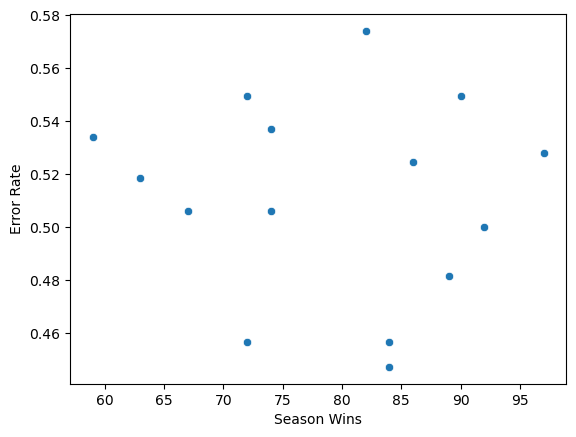

In [179]:
import seaborn as sns
sns.scatterplot(data=national_team_df, x="Season Wins", y="Error Rate")